# Chronic Care Cost Benchmarking


## 0. Life cycle of Machine learning Project

- Understanding the Problem Statement
- Data Collection
- Data Checks to perform
- Exploratory data analysis
- Data Pre-Processing
- Model Training
- Choose best model

## 1. Problem statement


## Introduction
The UHC Network Affordability team is focused on getting our members the right care for the best possible price in the most convenient manner. The task at hand is to perform an exploratory data analysis (EDA) on publicly available claim data for Medicare members in the US. Medicare is the government healthcare program for US citizens aged 65+.

The aim is to understand how the cost of treating certain chronic conditions varies across different providers.

## Data
The data is available on the CMS (Medicare) website:

- **Member Benefit Data**: [Download](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2009_Beneficiary_Summary_File_Sample_20.zip)
- **Outpatient Claim Data**: [Download](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Outpatient_Claims_Sample_20.zip)
- **User Documentation**: [Download](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_DUG.pdf)
- **Additional Info**: [CMS SynPUF Page](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs)

## Data Cleaning
- Convert the beneficiary summary file’s chronic illness columns (Boolean fields) into a single categorical variable, concatenating multiple true diagnoses.
- If a member has three or more chronic conditions, categorize these as “Multiple”.
- Join claims & benefit data.

## Basic Summaries
- What is the distribution of races?
- What is the most common chronic illness combination?
- Which chronic illness combination has the total highest cost?
- Which chronic illness combination has the highest cost per member?

## Benchmarking
The aim here is to understand the distribution of cost across providers treating members with these chronic illnesses. Benchmarking providers across types of care is often a helpful starting point to begin working with areas of excessive cost.

- For each provider (use `AT_PHYSN_NPI`) & chronic illness, calculate the cost per member.
- For each chronic illness combination, represent the distribution of costs per provider.
- How does this change if we filter out cases where a given Chronic Illness & Provider NPI combination only has one member?
- Which providers are consistently expensive across chronic illnesses they treat?

## Conclusion
During the interview, please be prepared to discuss the methodology, findings, and any challenges faced during the analysis.

## Limitations

- TODO: Draft:
    - The data is part of the synthethic sub sample from a set of 20 sub samples
    - This data is generated from 5% random sample of Medicare beneficiaries
    - File One: Beneficiaries from 2009
    - File Two: Outpatient data years 2008-2010

## 2. Import Data and Required Packages

####  Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [138]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display options to show all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#### Import the CSV Data as Pandas DataFrame

In [139]:
benef_2009_df  = pd.read_csv('data\DE1_0_2009_Beneficiary_Summary_File_Sample_20.csv')
claims_op_df = pd.read_csv('data\DE1_0_2008_to_2010_Outpatient_Claims_Sample_20.csv')

#### Show Top 5 Records

In [140]:
# Define a dictionary for renaming columns
benef_rename_dict = {
    'DESYNPUF_ID': 'Beneficiary_ID',
    'BENE_BIRTH_DT': 'Date_of_Birth',
    'BENE_DEATH_DT': 'Date_of_Death',
    'BENE_SEX_IDENT_CD': 'Sex',
    'BENE_RACE_CD': 'Race_Code',
    'BENE_ESRD_IND': 'ESRD_Indicator',
    'SP_STATE_CODE': 'State_Code',
    'BENE_COUNTY_CD': 'County_Code',
    'BENE_HI_CVRAGE_TOT_MONS': 'Coverage_Part_A_Months',
    'BENE_SMI_CVRAGE_TOT_MONS': 'Coverage_Part_B_Months',
    'BENE_HMO_CVRAGE_TOT_MONS': 'Coverage_HMO_Months',
    'PLAN_CVRG_MOS_NUM': 'Coverage_Part_D_Plan_Months',
    'SP_ALZHDMTA': 'Chronic_Alzheimer_Disease',
    'SP_CHF': 'Chronic_Heart_Failure',
    'SP_CHRNKIDN': 'Chronic_Kidney_Disease',
    'SP_CNCR': 'Chronic_Cancer',
    'SP_COPD': 'Chronic_Obstructive_Pulmonary_Disease',
    'SP_DEPRESSN': 'Chronic_Depression',
    'SP_DIABETES': 'Chronic_Diabetes',
    'SP_ISCHMCHT': 'Chronic_Ischemic_Heart_Disease',
    'SP_OSTEOPRS': 'Chronic_Osteoporosis',
    'SP_RA_OA': 'Chronic_Rheumatoid_Arthritis_Osteoarthritis',
    'SP_STRKETIA': 'Chronic_Stroke_TIA',
    'MEDREIMB_IP': 'Annual_Inpatient_Medicare_Paid',
    'BENRES_IP': 'Annual_Inpatient_Beneficiary_Paid',
    'PPPYMT_IP': 'Annual_Inpatient_3rd_Party_Paid',
    'MEDREIMB_OP': 'Annual_Outpatient_Medicare_Paid',
    'BENRES_OP': 'Annual_Outpatient_Beneficiary_Paid',
    'PPPYMT_OP': 'Annual_Outpatient_3rd_Party_Paid',
    'MEDREIMB_CAR': 'Annual_Carrier_Medicare_Paid',
    'BENRES_CAR': 'Annual_Carrier_Beneficiary_Paid',
    'PPPYMT_CAR': 'Annual_Carrier_3rd_Party_Paid',
}

# Rename columns using the dictionary
benef_2009_df.rename(columns=benef_rename_dict, inplace=True)

In [141]:
benef_2009_df.head()

,Beneficiary_ID,Date_of_Birth,Date_of_Death,Sex,Race_Code,ESRD_Indicator,State_Code,County_Code,Coverage_Part_A_Months,Coverage_Part_B_Months,Coverage_HMO_Months,Coverage_Part_D_Plan_Months,Chronic_Alzheimer_Disease,Chronic_Heart_Failure,Chronic_Kidney_Disease,Chronic_Cancer,Chronic_Obstructive_Pulmonary_Disease,Chronic_Depression,Chronic_Diabetes,Chronic_Ischemic_Heart_Disease,Chronic_Osteoporosis,Chronic_Rheumatoid_Arthritis_Osteoarthritis,Chronic_Stroke_TIA,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid
0,000002F7E0A96C32,19190701,NaN,2,2,0,5,400,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00001C24EE7B06AC,19360501,NaN,1,1,0,11,530,12,12,0,12,2,2,2,2,2,2,2,1,2,2,2,0.0,0.0,0.0,200.0,40.0,0.0,800.0,260.0,0.0
2,000072CF62193213,19310401,NaN,2,1,0,34,120,12,12,0,12,2,2,2,2,2,2,2,2,2,2,2,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0
3,0000DCD33779ED8A,19420501,NaN,2,2,0,11,190,12,12,0,12,1,1,2,1,2,2,2,2,2,2,2,0.0,0.0,0.0,90.0,20.0,0.0,930.0,200.0,0.0
4,0000F1EB530967F3,19350401,NaN,2,1,0,23,720,12,12,0,12,1,1,2,1,2,1,1,1,1,1,2,0.0,0.0,0.0,70.0,200.0,0.0,4950.0,1340.0,0.0


In [142]:
# Define a dictionary for renaming columns
outpatient_rename_dict = {
    'DESYNPUF_ID': 'Beneficiary_ID',
    'CLM_ID': 'Claim_ID',
    'SEGMENT': 'Claim_Line_Segment',
    'CLM_FROM_DT': 'Claim_Start_Date',
    'CLM_THRU_DT': 'Claim_End_Date',
    'PRVDR_NUM': 'Provider_Institution',
    'CLM_PMT_AMT': 'Claim_Medicare_Payment_Amount',
    'NCH_PRMRY_PYR_CLM_PD_AMT': 'Primary_Payer_Claim_Paid_Amount',
    'AT_PHYSN_NPI': 'Attending_Physician_NPI',
    'OP_PHYSN_NPI': 'Operating_Physician_NPI',
    'OT_PHYSN_NPI': 'Other_Physician_NPI',
    'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM': 'Beneficiary_Blood_Deductible_Liability_Amount',
    'ICD9_DGNS_CD_1': 'Diagnosis_Code_1',
    'ICD9_DGNS_CD_2': 'Diagnosis_Code_2',
    'ICD9_DGNS_CD_3': 'Diagnosis_Code_3',
    'ICD9_DGNS_CD_4': 'Diagnosis_Code_4',
    'ICD9_DGNS_CD_5': 'Diagnosis_Code_5',
    'ICD9_DGNS_CD_6': 'Diagnosis_Code_6',
    'ICD9_DGNS_CD_7': 'Diagnosis_Code_7',
    'ICD9_DGNS_CD_8': 'Diagnosis_Code_8',
    'ICD9_DGNS_CD_9': 'Diagnosis_Code_9',
    'ICD9_DGNS_CD_10': 'Diagnosis_Code_10',
    'ICD9_PRCDR_CD_1': 'Procedure_Code_1',
    'ICD9_PRCDR_CD_2': 'Procedure_Code_2',
    'ICD9_PRCDR_CD_3': 'Procedure_Code_3',
    'ICD9_PRCDR_CD_4': 'Procedure_Code_4',
    'ICD9_PRCDR_CD_5': 'Procedure_Code_5',
    'ICD9_PRCDR_CD_6': 'Procedure_Code_6',
    'NCH_BENE_PTB_DDCTBL_AMT': 'Beneficiary_Part_B_Deductible_Amount',
    'NCH_BENE_PTB_COINSRNC_AMT': 'Beneficiary_Part_B_Coinsurance_Amount',
    'ADMTNG_ICD9_DGNS_CD': 'Admitting_Diagnosis_Code',
    'HCPCS_CD_1': 'HCPCS_Code_1',
    'HCPCS_CD_2': 'HCPCS_Code_2',
    'HCPCS_CD_3': 'HCPCS_Code_3',
    'HCPCS_CD_4': 'HCPCS_Code_4',
    'HCPCS_CD_5': 'HCPCS_Code_5',
    'HCPCS_CD_45': 'HCPCS_Code_45'
}

# Rename columns using the dictionary
claims_op_df.rename(columns=outpatient_rename_dict, inplace=True)

In [143]:
claims_op_df.head()

,Beneficiary_ID,Claim_ID,Claim_Line_Segment,Claim_Start_Date,Claim_End_Date,Provider_Institution,Claim_Medicare_Payment_Amount,Primary_Payer_Claim_Paid_Amount,Attending_Physician_NPI,Operating_Physician_NPI,Other_Physician_NPI,Beneficiary_Blood_Deductible_Liability_Amount,Diagnosis_Code_1,Diagnosis_Code_2,Diagnosis_Code_3,Diagnosis_Code_4,Diagnosis_Code_5,Diagnosis_Code_6,Diagnosis_Code_7,Diagnosis_Code_8,Diagnosis_Code_9,Diagnosis_Code_10,Procedure_Code_1,Procedure_Code_2,Procedure_Code_3,Procedure_Code_4,Procedure_Code_5,Procedure_Code_6,Beneficiary_Part_B_Deductible_Amount,Beneficiary_Part_B_Coinsurance_Amount,Admitting_Diagnosis_Code,HCPCS_Code_1,HCPCS_Code_2,HCPCS_Code_3,HCPCS_Code_4,HCPCS_Code_5,HCPCS_CD_6,HCPCS_CD_7,HCPCS_CD_8,HCPCS_CD_9,HCPCS_CD_10,HCPCS_CD_11,HCPCS_CD_12,HCPCS_CD_13,HCPCS_CD_14,HCPCS_CD_15,HCPCS_CD_16,HCPCS_CD_17,HCPCS_CD_18,HCPCS_CD_19,HCPCS_CD_20,HCPCS_CD_21,HCPCS_CD_22,HCPCS_CD_23,HCPCS_CD_24,HCPCS_CD_25,HCPCS_CD_26,HCPCS_CD_27,HCPCS_CD_28,HCPCS_CD_29,HCPCS_CD_30,HCPCS_CD_31,HCPCS_CD_32,HCPCS_CD_33,HCPCS_CD_34,HCPCS_CD_35,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_Code_45
0,00001C24EE7B06AC,684562269783396,1,20090404.0,20090404.0,1100SK,200.0,0.0,1.298827e+09,NaN,NaN,0.0,74560,V5861,42731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,40.0,NaN,93303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00001C24EE7B06AC,684012269893042,1,20100310.0,20100310.0,1100SK,500.0,0.0,1.298827e+09,NaN,NaN,0.0,7879,V4589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,74000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000072CF62193213,684012269540703,1,20080130.0,20080130.0,1000AH,50.0,0.0,8.929521e+09,NaN,8.523329e+09,0.0,4019,73300,79431,V5869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,80053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000072CF62193213,684472269696971,1,20080301.0,20080301.0,1000AH,70.0,0.0,8.382688e+09,NaN,NaN,0.0,4019,71699,V7644,78605,7226,V1582,43882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20.0,NaN,36415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000072CF62193213,684122269778934,1,20080322.0,20080322.0,3400HK,40.0,0.0,4.404237e+09,NaN,NaN,0.0,1736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.0,1733,88305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
# Convert dates
claims_op_df['Claim_Start_Date'] = pd.to_datetime(claims_op_df['Claim_Start_Date'], format='%Y%m%d', errors='coerce')
claims_op_df['Claim_End_Date'] = pd.to_datetime(claims_op_df['Claim_End_Date'], format='%Y%m%d', errors='coerce')

# Filter claims data for 2009
claims_op_2009_df = claims_op_df[
    (claims_op_df['Claim_Start_Date'].dt.year == 2009) &
    (claims_op_df['Claim_End_Date'].dt.year == 2009)
]

# Check for any claims with invalid dates
invalid_dates = claims_op_df[claims_op_df['Claim_Start_Date'].isna() | claims_op_df['Claim_End_Date'].isna()]
print(f"Number of claims with invalid dates: {len(invalid_dates)}")

Number of claims with invalid dates: 11028


#### Shape of the dataset

In [145]:
benef_2009_df .shape

(114641, 32)

In [146]:
claims_op_df.shape

(790044, 76)

In [147]:
claims_op_2009_df.shape

(320824, 76)

## 3. Data Preprocessing

#### Data Checks to perform

- Check Missing values
- Check Duplicates
- Check the number of unique values of each column
- Check data type
- Check statistics of data set
- Check various categories present in the different categorical column

### 3.1. Beneficiary Dataset

#### Check Missing values

In [148]:
benef_2009_df.isna().sum()

Beneficiary_ID                                      0
Date_of_Birth                                       0
Date_of_Death                                  112811
Sex                                                 0
Race_Code                                           0
ESRD_Indicator                                      0
State_Code                                          0
County_Code                                         0
Coverage_Part_A_Months                              0
Coverage_Part_B_Months                              0
Coverage_HMO_Months                                 0
Coverage_Part_D_Plan_Months                         0
Chronic_Alzheimer_Disease                           0
Chronic_Heart_Failure                               0
Chronic_Kidney_Disease                              0
Chronic_Cancer                                      0
Chronic_Obstructive_Pulmonary_Disease               0
Chronic_Depression                                  0
Chronic_Diabetes            

In [149]:
benef_2009_df [~benef_2009_df.Date_of_Death.isna()].head()

,Beneficiary_ID,Date_of_Birth,Date_of_Death,Sex,Race_Code,ESRD_Indicator,State_Code,County_Code,Coverage_Part_A_Months,Coverage_Part_B_Months,Coverage_HMO_Months,Coverage_Part_D_Plan_Months,Chronic_Alzheimer_Disease,Chronic_Heart_Failure,Chronic_Kidney_Disease,Chronic_Cancer,Chronic_Obstructive_Pulmonary_Disease,Chronic_Depression,Chronic_Diabetes,Chronic_Ischemic_Heart_Disease,Chronic_Osteoporosis,Chronic_Rheumatoid_Arthritis_Osteoarthritis,Chronic_Stroke_TIA,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid
140,0050D66259ADF7AC,19210701,20090101.0,2,1,0,18,0,12,12,0,12,2,2,2,2,2,1,1,1,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,00539E095CB3CD42,19311201,20091101.0,2,1,0,46,170,12,12,0,0,2,2,2,2,2,2,2,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,00C6A75C4B231127,19390901,20090601.0,2,1,Y,52,700,12,12,12,12,2,1,1,2,1,2,1,1,2,2,2,14000.0,1068.0,0.0,7100.0,2020.0,0.0,5730.0,1990.0,0.0
381,00D401552AA18A58,19370201,20090601.0,1,3,0,24,610,12,12,12,12,2,2,2,2,2,2,2,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385,00D6FE25DB4A36CB,19370901,20091001.0,2,1,0,36,330,12,12,0,12,2,1,2,2,2,2,1,1,2,2,2,0.0,0.0,0.0,1130.0,490.0,0.0,1400.0,420.0,0.0


- **Notes:**
    - Missing values: There are no missing values in the data set except date of death as expected
        - TODO: Rows with date of death filled, what can be done with this data?

#### Check Duplicates

In [150]:
benef_2009_df.duplicated().sum()

np.int64(0)

- **Notes:**
    - Duplicates: There are no duplicate rows

#### Check Unique Values

In [151]:
benef_2009_df.nunique()

Beneficiary_ID                                 114641
Date_of_Birth                                     900
Date_of_Death                                      12
Sex                                                 2
Race_Code                                           4
ESRD_Indicator                                      2
State_Code                                         52
County_Code                                       310
Coverage_Part_A_Months                             13
Coverage_Part_B_Months                             13
Coverage_HMO_Months                                13
Coverage_Part_D_Plan_Months                        13
Chronic_Alzheimer_Disease                           2
Chronic_Heart_Failure                               2
Chronic_Kidney_Disease                              2
Chronic_Cancer                                      2
Chronic_Obstructive_Pulmonary_Disease               2
Chronic_Depression                                  2
Chronic_Diabetes            

- **Notes:**
    - Data includes:
        - Demographic data
        - Coverage details
        - Chronic conditions
        - Reimbursement information
    - TODO: Plots connectign Chronic kidney disease and ESRD Indicator
    - TODO: Plots check correlation between chronic disease features before combining them
    - TODO: Chronic conditions are time varying could be time series if other beneficiary data is provided to add in notes

#### Check Data Types

In [152]:
# Check Null and Dtypes
benef_2009_df .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114641 entries, 0 to 114640
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Beneficiary_ID                               114641 non-null  object 
 1   Date_of_Birth                                114641 non-null  int64  
 2   Date_of_Death                                1830 non-null    float64
 3   Sex                                          114641 non-null  int64  
 4   Race_Code                                    114641 non-null  int64  
 5   ESRD_Indicator                               114641 non-null  object 
 6   State_Code                                   114641 non-null  int64  
 7   County_Code                                  114641 non-null  int64  
 8   Coverage_Part_A_Months                       114641 non-null  int64  
 9   Coverage_Part_B_Months                       114641 non-nul

In [153]:
# Define which columns to convert to categorical
categorical_columns = [
    'Sex', 'Race_Code', 'ESRD_Indicator', 'State_Code', 'County_Code',
    'Chronic_Alzheimer_Disease', 'Chronic_Heart_Failure', 'Chronic_Kidney_Disease', 
    'Chronic_Cancer', 'Chronic_Obstructive_Pulmonary_Disease', 'Chronic_Depression', 
    'Chronic_Diabetes', 'Chronic_Ischemic_Heart_Disease', 'Chronic_Osteoporosis', 
    'Chronic_Rheumatoid_Arthritis_Osteoarthritis', 'Chronic_Stroke_TIA'
]

# Convert columns to categorical data types
benef_2009_df[categorical_columns] = benef_2009_df [categorical_columns].astype('category')

#### Feature: Date Columns

In [154]:
# Convert 'Date_of_Birth' to datetime format using the specific format YYYYMMDD
benef_2009_df ['Date_of_Birth'] = pd.to_datetime(benef_2009_df ['Date_of_Birth'], format='%Y%m%d', errors='coerce')

# Convert 'Date_of_Death' to datetime format (assuming it's also in a similar format)
benef_2009_df ['Date_of_Death'] = pd.to_datetime(benef_2009_df ['Date_of_Death'], format='%Y%m%d', errors='coerce')

# Check unique birth years after conversion
# print(benef_2009_df ['Date_of_Birth'].dt.year.unique())

In [155]:
# Define reference year
reference_year = 2009

In [156]:
# Calculate Age as of the reference year
benef_2009_df ['Age_as_of_2009'] = reference_year - benef_2009_df ['Date_of_Birth'].dt.year

# Calculate Age at Death: TODO CHECK IF THIS NEEDED FOR ANALYSIS
# benef_2009_df ['Age_at_Death'] = benef_2009_df ['Date_of_Death'].dt.year - benef_2009_df ['Date_of_Birth'].dt.year

# Create a single 'Age' column
#benef_2009_df ['Age'] = benef_2009_df .apply(
#    lambda row: row['Age_at_Death'] if pd.notna(row['Date_of_Death']) else row['Age_as_of_2009'],
#    axis=1
#)

In [157]:
# Extract year from 'Date_of_Birth'
benef_2009_df ['Year_of_Birth'] = benef_2009_df ['Date_of_Birth'].dt.year

# Function to categorize year of birth
def categorize_year_of_birth(year):
    if year < 1924:
        return 'Pre-1924'
    elif 1924 <= year <= 1928:
        return '1924–1928'
    elif 1929 <= year <= 1933:
        return '1929–1933'
    elif 1934 <= year <= 1938:
        return '1934–1938'
    elif 1939 <= year <= 1943:
        return '1939–1943'
    else:
        return 'Post-1943'

# Apply the function to create a new column
benef_2009_df ['Year_of_Birth_Category'] = benef_2009_df ['Year_of_Birth'].apply(categorize_year_of_birth)

In [158]:
# Drop intermediate columns if no longer needed: TODO
benef_2009_df  = benef_2009_df .drop(columns=['Date_of_Birth', 'Date_of_Death'])

# Drop intermediate columns if no longer needed: TODO
# benef_2009_df  = benef_2009_df .drop(columns=['Age_as_of_2009', 'Age_at_Death'])

# Drop intermediate columns: TODO
# benef_2009_df  = benef_2009_df .drop(columns=['Year_of_Birth'])

In [159]:
# Counter(benef_2009_df .Year_of_Birth_Category)

#### Feature: Total Paid Columns

In [160]:
# Create a new column for total paid by summing relevant columns
benef_2009_df ['Annual_Inpatient_Total_Paid'] = benef_2009_df ['Annual_Inpatient_Medicare_Paid'] + benef_2009_df ['Annual_Inpatient_Beneficiary_Paid'] + benef_2009_df ['Annual_Inpatient_3rd_Party_Paid']
benef_2009_df ['Annual_Outpatient_Total_Paid'] = benef_2009_df ['Annual_Outpatient_Medicare_Paid'] + benef_2009_df ['Annual_Outpatient_Beneficiary_Paid'] + benef_2009_df ['Annual_Outpatient_3rd_Party_Paid']
benef_2009_df ['Annual_Carrier_Total_Paid'] = benef_2009_df ['Annual_Carrier_Medicare_Paid'] + benef_2009_df ['Annual_Carrier_Beneficiary_Paid'] + benef_2009_df ['Annual_Carrier_3rd_Party_Paid']

#### Feature: Reassign Categories

In [161]:
# Reassign 'Sex' categories
benef_2009_df ['Sex'] = benef_2009_df ['Sex'].map({1: 'Male', 2: 'Female'})

# Check the distribution after mapping
Counter(benef_2009_df .Sex)

Counter({'Female': 63545, 'Male': 51096})

In [162]:
# Verifying Race distribution
# Counter(benef_2009_df .Race_Code)
# (4916+2630)/(94945+12141+4916+2639)

In [163]:
# Reassign the 'Race_Code' categories
race_mapping = {1: 'White', 2: 'Black', 3: 'Other/Hispanic', 4: 'Other/Hispanic'}

# Apply the mapping to the Race_Code column
benef_2009_df ['Race_Code'] = benef_2009_df ['Race_Code'].map(race_mapping)

# Check the result
Counter(benef_2009_df ['Race_Code'])

# TODO: CORRECT THIS 4 IS NOT BEING SET

Counter({'White': 94945, 'Black': 12141, 'Other/Hispanic': 4916, nan: 2639})

#### Feature: Chronic Columns

In [164]:
# Analysing distribution
# Counter(benef_2009_df .Chronic_Alzheimer_Disease)
# Counter(benef_2009_df .Chronic_Heart_Failure)

In [165]:
# Convert 1 to Yes and 2 to No or 0 in chronic disease columns
chronic_columns = [
    'Chronic_Alzheimer_Disease', 
    'Chronic_Heart_Failure', 
    'Chronic_Kidney_Disease', 
    'Chronic_Cancer', 
    'Chronic_Obstructive_Pulmonary_Disease', 
    'Chronic_Depression', 
    'Chronic_Diabetes', 
    'Chronic_Ischemic_Heart_Disease', 
    'Chronic_Osteoporosis', 
    'Chronic_Rheumatoid_Arthritis_Osteoarthritis', 
    'Chronic_Stroke_TIA'
]

# Replacing 1 with Yes and 2 with No or 0
benef_2009_df [chronic_columns] = benef_2009_df [chronic_columns].replace({2: 0})

# Ensure the chronic condition columns are numeric (0/1) before summing
benef_2009_df [chronic_columns] = benef_2009_df [chronic_columns].apply(pd.to_numeric, errors='coerce')

# Add a column to count the number of chronic conditions for each beneficiary
benef_2009_df ['Chronic_Illness_Count'] = benef_2009_df [chronic_columns].sum(axis=1)


In [166]:
print(benef_2009_df .Chronic_Illness_Count.value_counts())

Chronic_Illness_Count
0     36984
1     12959
2     12874
3     12695
4     11475
5      9811
6      7676
7      5449
8      3087
9      1290
10      308
11       33
Name: count, dtype: int64


In [167]:
# Clean chronic condition names by removing 'Chronic_' prefix and '_Disease' suffix
chronic_columns_clean = [col.replace('Chronic_', '').replace('_Disease', '') for col in chronic_columns]

# Define a function to concatenate chronic illnesses into a single categorical variable
def combine_chronic_conditions(row):
    conditions = sorted([chronic_columns_clean[i] for i in range(len(chronic_columns)) if row[chronic_columns[i]] == 1])
    
    if len(conditions) >= 3:
        return 'Multiple'
    elif len(conditions) == 0:
        return 'None'
    else:
        return ', '.join(conditions)

# Apply the function to create the new categorical column
benef_2009_df ['Chronic_Illness_Combination'] = benef_2009_df .apply(combine_chronic_conditions, axis=1)

# Check the value counts of the resulting Chronic_Illness_Combination column
print(benef_2009_df .Chronic_Illness_Combination.value_counts())

Chronic_Illness_Combination
Multiple                                                      51824
None                                                          36984
Ischemic_Heart                                                 4167
Diabetes, Ischemic_Heart                                       2043
Diabetes                                                       1928
Heart_Failure                                                  1490
Depression                                                     1485
Heart_Failure, Ischemic_Heart                                  1469
Osteoporosis                                                   1163
Alzheimer                                                      1159
Depression, Ischemic_Heart                                      763
Ischemic_Heart, Osteoporosis                                    721
Diabetes, Heart_Failure                                         649
Alzheimer, Ischemic_Heart                                       623
Rheumatoid_Arthritis

In [168]:
benef_2009_df .head()

,Beneficiary_ID,Sex,Race_Code,ESRD_Indicator,State_Code,County_Code,Coverage_Part_A_Months,Coverage_Part_B_Months,Coverage_HMO_Months,Coverage_Part_D_Plan_Months,Chronic_Alzheimer_Disease,Chronic_Heart_Failure,Chronic_Kidney_Disease,Chronic_Cancer,Chronic_Obstructive_Pulmonary_Disease,Chronic_Depression,Chronic_Diabetes,Chronic_Ischemic_Heart_Disease,Chronic_Osteoporosis,Chronic_Rheumatoid_Arthritis_Osteoarthritis,Chronic_Stroke_TIA,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid,Age_as_of_2009,Year_of_Birth,Year_of_Birth_Category,Annual_Inpatient_Total_Paid,Annual_Outpatient_Total_Paid,Annual_Carrier_Total_Paid,Chronic_Illness_Count,Chronic_Illness_Combination
0,000002F7E0A96C32,Female,Black,0,5,400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,1919,Pre-1924,0.0,0.0,0.0,0,None
1,00001C24EE7B06AC,Male,White,0,11,530,12,12,0,12,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,200.0,40.0,0.0,800.0,260.0,0.0,73,1936,1934–1938,0.0,240.0,1060.0,1,Ischemic_Heart
2,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None
3,0000DCD33779ED8A,Female,Black,0,11,190,12,12,0,12,1,1,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,90.0,20.0,0.0,930.0,200.0,0.0,67,1942,1939–1943,0.0,110.0,1130.0,3,Multiple
4,0000F1EB530967F3,Female,White,0,23,720,12,12,0,12,1,1,0,1,0,1,1,1,1,1,0,0.0,0.0,0.0,70.0,200.0,0.0,4950.0,1340.0,0.0,74,1935,1934–1938,0.0,270.0,6290.0,8,Multiple


#### Data Checks: TODO rearrange this section

In [169]:
print(f"Inpatient Total Paid Mean: {benef_2009_df .Annual_Inpatient_Total_Paid.mean()}")
print(f"Inpatient Medicare Paid Mean: {benef_2009_df .Annual_Inpatient_Medicare_Paid.mean()}")
print(f"Inpatient Beneficiary Paid Mean: {benef_2009_df .Annual_Inpatient_Beneficiary_Paid.mean()}")
print(f"Inpatient 3rd Party Paid Mean: {benef_2009_df .Annual_Inpatient_3rd_Party_Paid.mean()}")

print(f"Outpatient Total Paid Mean: {benef_2009_df .Annual_Outpatient_Total_Paid.mean()}")
print(f"Outpatient Medicare Paid Mean: {benef_2009_df .Annual_Outpatient_Medicare_Paid.mean()}")
print(f"Outpatient Beneficiary Paid Mean: {benef_2009_df .Annual_Outpatient_Beneficiary_Paid.mean()}")
print(f"Outpatient 3rd Party Paid Mean: {benef_2009_df .Annual_Outpatient_3rd_Party_Paid.mean()}")

print(f"Carrier Total Paid Mean: {benef_2009_df .Annual_Carrier_Total_Paid.mean()}")
print(f"Carrier Medicare Paid Mean: {benef_2009_df .Annual_Carrier_Medicare_Paid.mean()}")
print(f"Carrier Beneficiary Paid Mean: {benef_2009_df .Annual_Carrier_Beneficiary_Paid.mean()}")
print(f"Carrier 3rd Party Paid Mean: {benef_2009_df .Annual_Carrier_3rd_Party_Paid.mean()}")

Inpatient Total Paid Mean: 2507.3920499646724
Inpatient Medicare Paid Mean: 2158.4399996510847
Inpatient Beneficiary Paid Mean: 247.42205668129202
Inpatient 3rd Party Paid Mean: 101.5299936322956
Outpatient Total Paid Mean: 1027.6489214155495
Outpatient Medicare Paid Mean: 762.0271107195506
Outpatient Beneficiary Paid Mean: 234.91063406634623
Outpatient 3rd Party Paid Mean: 30.711176629652567
Carrier Total Paid Mean: 1733.2571244144765
Carrier Medicare Paid Mean: 1337.588035694036
Carrier Beneficiary Paid Mean: 374.5575317731004
Carrier 3rd Party Paid Mean: 21.111556947339956


- **Notes:**
    - Assumptions: TODO reframe if needed
        - Based on the distribution of Sex(Male 44.4, Female 55.6) from the user guide reassigning categories to Sex
        - Based on the distribution of Race(White 82.8, Black 10.7, Other/Hispanic 6.6) from user guide reassigning categories to Race
    - Data checks: TODO compare other distributions too

#### Check Statistics

In [170]:
benef_2009_df .describe().T

,count,mean,std,min,25%,50%,75%,max
Coverage_Part_A_Months,114641.0,11.228653,2.926545,0.0,12.0,12.0,12.0,12.0
Coverage_Part_B_Months,114641.0,11.113284,3.093597,0.0,12.0,12.0,12.0,12.0
Coverage_HMO_Months,114641.0,3.332289,5.303927,0.0,0.0,0.0,12.0,12.0
Coverage_Part_D_Plan_Months,114641.0,9.070237,4.869408,0.0,6.0,12.0,12.0,12.0
Chronic_Alzheimer_Disease,114641.0,0.230851,0.421379,0.0,0.0,0.0,0.0,1.0
Chronic_Heart_Failure,114641.0,0.342042,0.474396,0.0,0.0,0.0,1.0,1.0
Chronic_Kidney_Disease,114641.0,0.207674,0.405644,0.0,0.0,0.0,0.0,1.0
Chronic_Cancer,114641.0,0.081009,0.272851,0.0,0.0,0.0,0.0,1.0
Chronic_Obstructive_Pulmonary_Disease,114641.0,0.157527,0.364298,0.0,0.0,0.0,0.0,1.0
Chronic_Depression,114641.0,0.246099,0.430739,0.0,0.0,0.0,0.0,1.0


In [171]:
benef_2009_df .head()

,Beneficiary_ID,Sex,Race_Code,ESRD_Indicator,State_Code,County_Code,Coverage_Part_A_Months,Coverage_Part_B_Months,Coverage_HMO_Months,Coverage_Part_D_Plan_Months,Chronic_Alzheimer_Disease,Chronic_Heart_Failure,Chronic_Kidney_Disease,Chronic_Cancer,Chronic_Obstructive_Pulmonary_Disease,Chronic_Depression,Chronic_Diabetes,Chronic_Ischemic_Heart_Disease,Chronic_Osteoporosis,Chronic_Rheumatoid_Arthritis_Osteoarthritis,Chronic_Stroke_TIA,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid,Age_as_of_2009,Year_of_Birth,Year_of_Birth_Category,Annual_Inpatient_Total_Paid,Annual_Outpatient_Total_Paid,Annual_Carrier_Total_Paid,Chronic_Illness_Count,Chronic_Illness_Combination
0,000002F7E0A96C32,Female,Black,0,5,400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,1919,Pre-1924,0.0,0.0,0.0,0,None
1,00001C24EE7B06AC,Male,White,0,11,530,12,12,0,12,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,200.0,40.0,0.0,800.0,260.0,0.0,73,1936,1934–1938,0.0,240.0,1060.0,1,Ischemic_Heart
2,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None
3,0000DCD33779ED8A,Female,Black,0,11,190,12,12,0,12,1,1,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,90.0,20.0,0.0,930.0,200.0,0.0,67,1942,1939–1943,0.0,110.0,1130.0,3,Multiple
4,0000F1EB530967F3,Female,White,0,23,720,12,12,0,12,1,1,0,1,0,1,1,1,1,1,0,0.0,0.0,0.0,70.0,200.0,0.0,4950.0,1340.0,0.0,74,1935,1934–1938,0.0,270.0,6290.0,8,Multiple


#### Initial Observations

- **Data includes:**
    - Demographic data
    - Coverage details
    - Chronic conditions
    - Reimbursement information

- **Coverage Months:**
    - Part A/B: Most beneficiaries have 12 months of coverage, with some variation.
    - HMO: Significant variability; many have no coverage.
    - Part D: Most beneficiaries have 12 months, with substantial variability.

- **Reimbursement and Responsibility:** High variability in reimbursements and responsibilities, especially in inpatient and outpatient categories, with a few extreme values.
    - Inpatient Medical Reimbursement:
        - High mean `$2158.44` but extremely high standard deviation `$7167.90`, indicating a few very high values are **skewing** the data.
    - Inpatient Beneficiary Responsibility:
        - Mean responsibility is `$247.42` with high variability (standard deviation of `$781.24`), showing considerable differences in what beneficiaries owe.
    - Inpatient Primary Payer Reimbursement:
        - Average reimbursement is `$101.53` with a large standard deviation `$1951.36`, suggesting a few extreme outliers.
    - Outpatient Medical Reimbursement:
        - Mean is `$762.03` with a high standard deviation `$1876.65`, reflecting a mix of mostly lower and a few very high reimbursements.
    - Outpatient Beneficiary Responsibility:
        - Average responsibility is `$234.91` with significant variability (standard deviation of `$539.39`).
    - Outpatient Primary Payer Reimbursement:
        - Mean is `$30.71` with moderate standard deviation (`$414.68`), indicating some very high reimbursements.
    - Carrier Medical Reimbursement:
        - Mean is `$1337.59` with a high standard deviation (`$1525.17`), highlighting wide variability in reimbursement amounts.
    - Carrier Beneficiary Responsibility:
        - Average is `$374.56` with a high standard deviation (`$423.54`), showing considerable variability in what beneficiaries are responsible for.
    - Carrier Primary Payer Reimbursement:
        - Mean is `$21.11` with a standard deviation of `$96.01`, indicating many low values with a few higher amounts.

- **Age:**
    - Average age is around 38 years with moderate variation.
 
  - TODO: Find inconsistencies with the outpatient columns from beneficiary with outpatient df columns
 
      - Remember age is 39 seems weird
   

#### Actions to be taken:

- TODO: Check for outliers in skewed data
- TODO: Correlation analysis
- TODO: Check Age filter 65+

#### Basic Summaries

##### Q: What is Distribution of races?

In [172]:

# ! What is the distribution of races?

# Count the number of beneficiaries in each race category
race_counts = benef_2009_df ['Race_Code'].value_counts()
print(race_counts)

Race_Code
White             94945
Black             12141
Other/Hispanic     4916
Name: count, dtype: int64


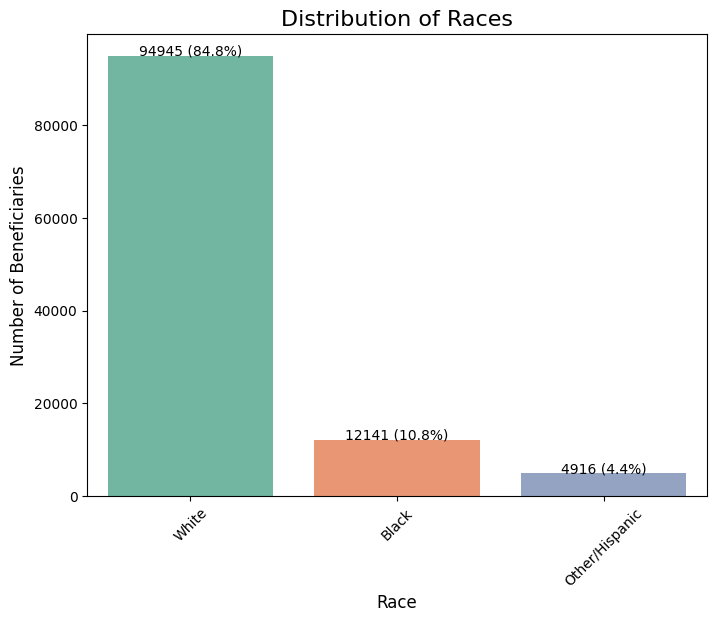

In [173]:
# Calculate percentages
total = race_counts.sum()
race_percentages = (race_counts / total) * 100

# Bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=race_counts.index, y=race_counts.values, palette='Set2')

# Add count and percentage annotations
for i, (count, pct) in enumerate(zip(race_counts.values, race_percentages)):
    ax.text(i, count + 100, f'{count} ({pct:.1f}%)', ha='center', fontsize=10)

plt.title('Distribution of Races', fontsize=16)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Number of Beneficiaries', fontsize=12)
plt.xticks(rotation=45)
plt.show()

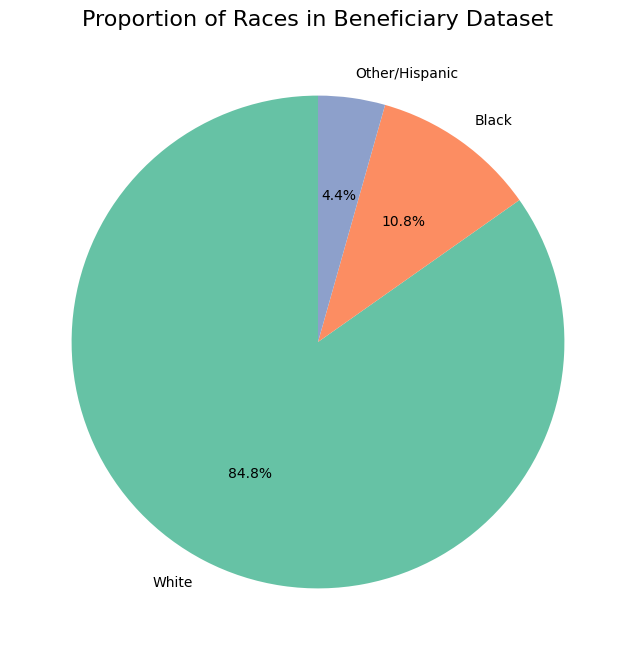

In [174]:
# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2', len(race_counts)))
plt.title('Proportion of Races in Beneficiary Dataset', fontsize=16)
plt.show()

##### Q: What is the most common chronic illness combination?

In [175]:
benef_2009_df.head()

,Beneficiary_ID,Sex,Race_Code,ESRD_Indicator,State_Code,County_Code,Coverage_Part_A_Months,Coverage_Part_B_Months,Coverage_HMO_Months,Coverage_Part_D_Plan_Months,Chronic_Alzheimer_Disease,Chronic_Heart_Failure,Chronic_Kidney_Disease,Chronic_Cancer,Chronic_Obstructive_Pulmonary_Disease,Chronic_Depression,Chronic_Diabetes,Chronic_Ischemic_Heart_Disease,Chronic_Osteoporosis,Chronic_Rheumatoid_Arthritis_Osteoarthritis,Chronic_Stroke_TIA,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid,Age_as_of_2009,Year_of_Birth,Year_of_Birth_Category,Annual_Inpatient_Total_Paid,Annual_Outpatient_Total_Paid,Annual_Carrier_Total_Paid,Chronic_Illness_Count,Chronic_Illness_Combination
0,000002F7E0A96C32,Female,Black,0,5,400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,1919,Pre-1924,0.0,0.0,0.0,0,None
1,00001C24EE7B06AC,Male,White,0,11,530,12,12,0,12,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,200.0,40.0,0.0,800.0,260.0,0.0,73,1936,1934–1938,0.0,240.0,1060.0,1,Ischemic_Heart
2,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None
3,0000DCD33779ED8A,Female,Black,0,11,190,12,12,0,12,1,1,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,90.0,20.0,0.0,930.0,200.0,0.0,67,1942,1939–1943,0.0,110.0,1130.0,3,Multiple
4,0000F1EB530967F3,Female,White,0,23,720,12,12,0,12,1,1,0,1,0,1,1,1,1,1,0,0.0,0.0,0.0,70.0,200.0,0.0,4950.0,1340.0,0.0,74,1935,1934–1938,0.0,270.0,6290.0,8,Multiple


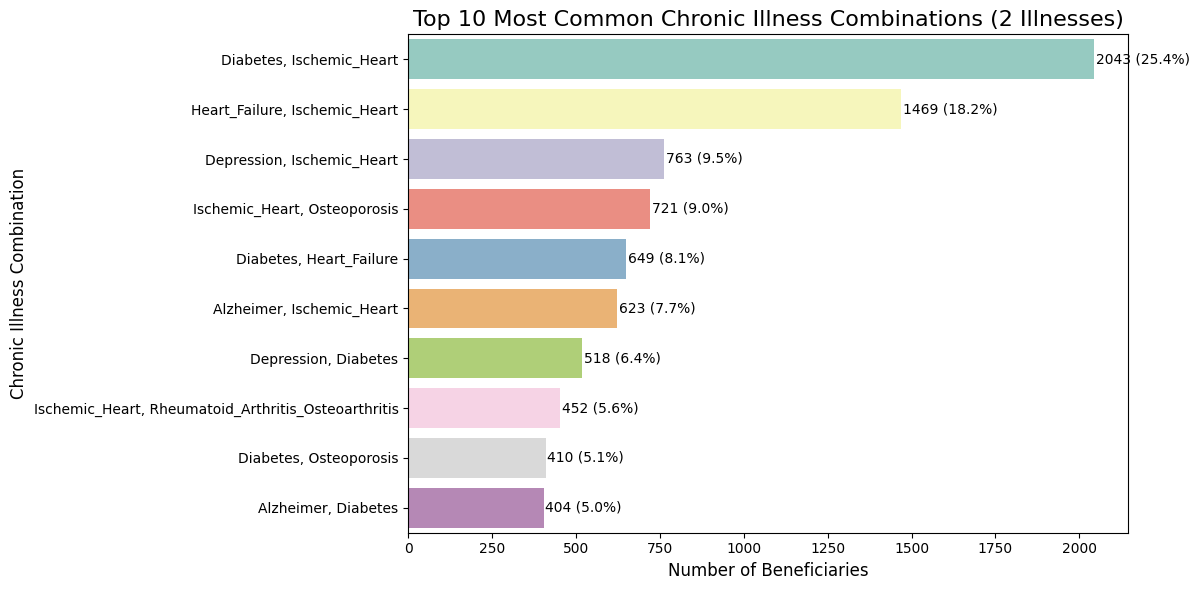

In [176]:
# Filter for beneficiaries with exactly 2 chronic conditions
df_two_illnesses = benef_2009_df[benef_2009_df['Chronic_Illness_Count'] == 2]

# Group by the Chronic_Illness_Combination and get the count
top_combinations = df_two_illnesses['Chronic_Illness_Combination'].value_counts().nlargest(10)

# Calculate percentages
percentages = top_combinations / top_combinations.sum() * 100

# Plot the histogram with flipped x and y axes
plt.figure(figsize=(12, 6))
sns.barplot(y=top_combinations.index, x=top_combinations.values, palette='Set3')

# Add count and percentage labels on the bars
for i, (count, perc) in enumerate(zip(top_combinations.values, percentages)):
    plt.text(count + 5, i, f'{count} ({perc:.1f}%)', va='center', fontsize=10)

plt.title('Top 10 Most Common Chronic Illness Combinations (2 Illnesses)', fontsize=16)
plt.ylabel('Chronic Illness Combination', fontsize=12)
plt.xlabel('Number of Beneficiaries', fontsize=12)
plt.tight_layout()
plt.show()

- **A:**
    - The most common chronic illness combination is Diabetes and Ischemic Heart condition

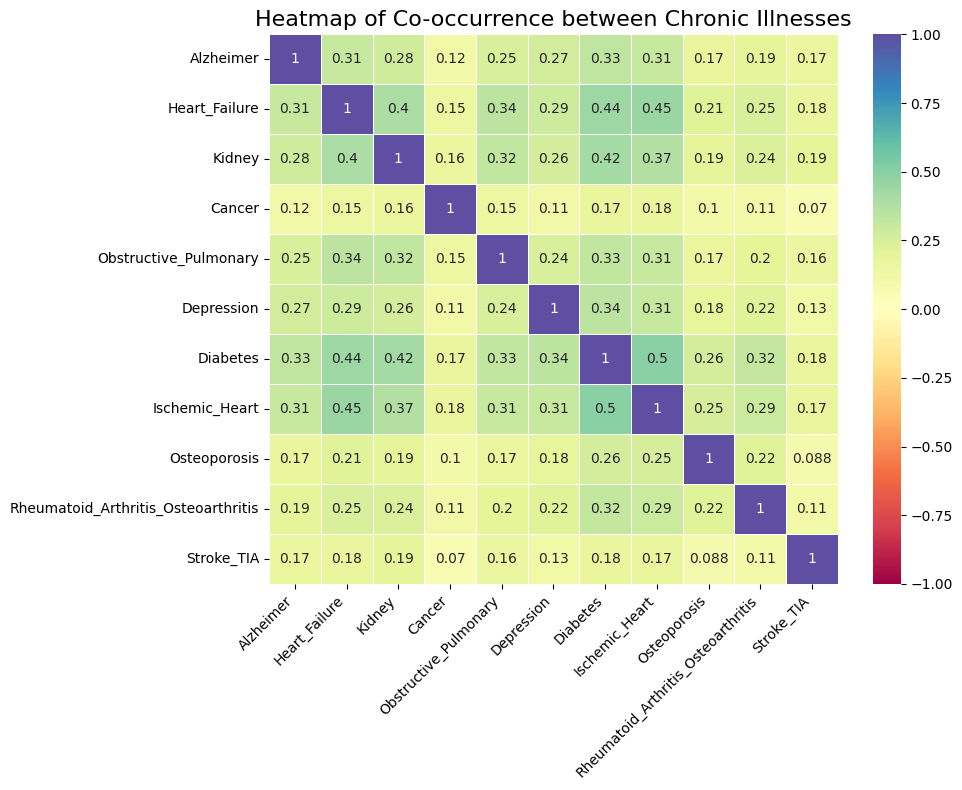

In [177]:
# Define a function to rename columns
def clean_column_name(col_name):
    return col_name.replace('Chronic_', '').replace('_Disease', '')

# Subset the dataframe to include only the chronic illness columns
chronic_df = benef_2009_df[chronic_columns]

# Rename the columns
chronic_df.columns = [clean_column_name(col) for col in chronic_df.columns]

# Compute the correlation matrix
chronic_corr = chronic_df.corr()

# Plot the heatmap with a better color palette
plt.figure(figsize=(10, 8))
sns.heatmap(chronic_corr, annot=True, cmap='Spectral', linewidths=0.5, vmin=-1, vmax=1, center=0)

# Customize the heatmap
plt.title('Heatmap of Co-occurrence between Chronic Illnesses', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

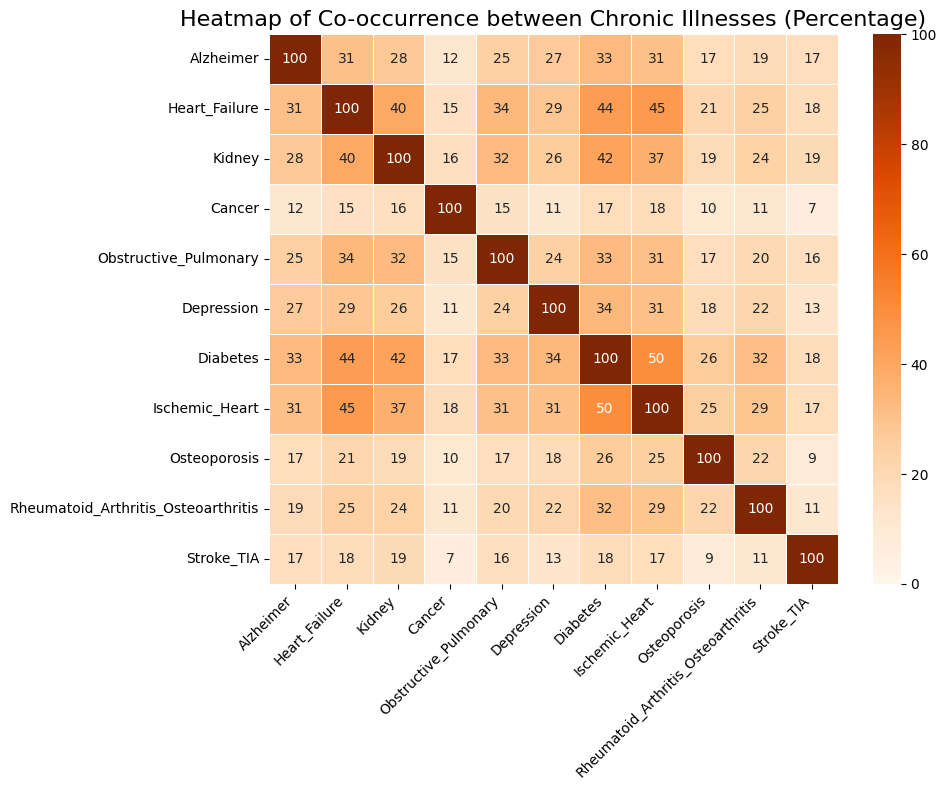

In [178]:
# Subset the dataframe to include only the chronic illness columns
chronic_df = benef_2009_df[chronic_columns]

# Rename the columns
chronic_df.columns = [clean_column_name(col) for col in chronic_df.columns]

# Compute the correlation matrix
chronic_corr = chronic_df.corr()

# Convert correlation values to percentages
chronic_corr_percent = chronic_corr * 100

# Plot the heatmap of percentages with Spectral color palette
plt.figure(figsize=(10, 8))
ax = sns.heatmap(chronic_corr_percent, annot=True, fmt='.0f', cmap='Oranges', linewidths=0.5, vmin=0, vmax=100)

# Customize the heatmap
plt.title('Heatmap of Co-occurrence between Chronic Illnesses (Percentage)', fontsize=16)
plt.xticks(ticks=np.arange(len(chronic_corr_percent.columns)) + 0.5, labels=chronic_corr_percent.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(ticks=np.arange(len(chronic_corr_percent.index)) + 0.5, labels=chronic_corr_percent.index, rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [179]:
# Create a DataFrame for the treemap
treemap_df = top_combinations.reset_index()
treemap_df.columns = ['Chronic_Illness_Combination', 'Count']

# Plot the treemap
fig = px.treemap(treemap_df, path=['Chronic_Illness_Combination'], values='Count',
                 color='Count', color_continuous_scale='Blues',
                 title='Top 10 Most Common Chronic Illness Combinations (2 Illnesses)')

fig.show()


NameError: name 'px' is not defined

In [180]:

# ?: 

##### Data check: Medicare payment Annual vs Claims

count    72072.000000
mean        13.886946
std        189.529882
min        -60.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       7700.000000
Name: Difference, dtype: float64


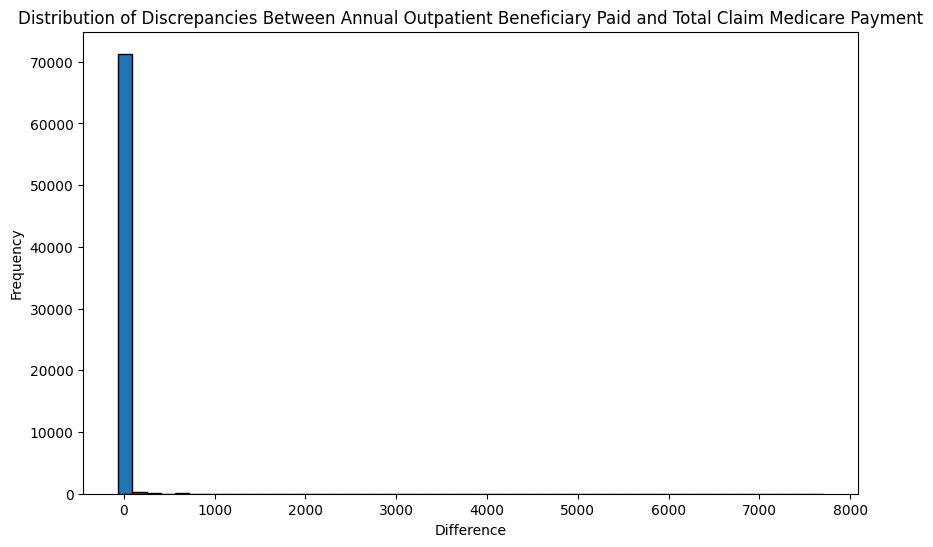

In [181]:
# Aggregate claim amounts by Beneficiary_ID
# TODO: Verify data integrity
annual_claim_amounts = claims_op_2009_df.groupby('Beneficiary_ID')['Claim_Medicare_Payment_Amount'].sum().reset_index()
annual_claim_amounts.rename(columns={'Claim_Medicare_Payment_Amount': 'Total_Claim_Medicare_Payment'}, inplace=True)

# Merge aggregated claim amounts with beneficiary data
merged_df = pd.merge(benef_2009_df, annual_claim_amounts, on='Beneficiary_ID', how='left')

# Check for discrepancies
discrepancies = merged_df[['Annual_Outpatient_Medicare_Paid', 'Total_Claim_Medicare_Payment']].dropna()
discrepancies['Difference'] = discrepancies['Annual_Outpatient_Medicare_Paid'] - discrepancies['Total_Claim_Medicare_Payment']
# Summary statistics of discrepancies
print(discrepancies['Difference'].describe())

plt.figure(figsize=(10, 6))
plt.hist(discrepancies['Difference'], bins=50, edgecolor='k')
plt.title('Distribution of Discrepancies Between Annual Outpatient Beneficiary Paid and Total Claim Medicare Payment')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [182]:
# Find outliers
outliers = discrepancies[discrepancies['Difference'].abs() > discrepancies['Difference'].std() * 3]
len(outliers)

# TODO: Analyze these: Annual medicare payment is a sum of other amounts as well


426

In [183]:
# Creating Total cost 
benef_2009_df['Total_Cost'] = benef_2009_df.Annual_Inpatient_Total_Paid + benef_2009_df.Annual_Outpatient_Total_Paid + benef_2009_df.Annual_Carrier_Total_Paid

In [184]:
# Sum the outpatient total paid amount from the beneficiary dataset
total_outpatient_beneficiary = benef_2009_df['Annual_Outpatient_Total_Paid'].sum()

In [185]:
total_outpatient_beneficiary

np.float64(117810700.0)

In [186]:
# Sum the claims data for outpatient services
total_outpatient_claims = claims_op_2009_df[['Claim_Medicare_Payment_Amount', 'Primary_Payer_Claim_Paid_Amount', 'Beneficiary_Part_B_Deductible_Amount', 'Beneficiary_Part_B_Coinsurance_Amount', 'Beneficiary_Blood_Deductible_Liability_Amount']].sum().sum()


In [187]:
print(f"Total Outpatient Claims from Claims Data: ${total_outpatient_claims:,.2f}")
print(f"Total Outpatient Paid Amount from Beneficiary Data: ${total_outpatient_beneficiary:,.2f}")

Total Outpatient Claims from Claims Data: $116,491,070.00
Total Outpatient Paid Amount from Beneficiary Data: $117,810,700.00


##### Q: Which chronic illness combination has the total highest cost?

In [188]:
benef_2009_df.head()

,Beneficiary_ID,Sex,Race_Code,ESRD_Indicator,State_Code,County_Code,Coverage_Part_A_Months,Coverage_Part_B_Months,Coverage_HMO_Months,Coverage_Part_D_Plan_Months,Chronic_Alzheimer_Disease,Chronic_Heart_Failure,Chronic_Kidney_Disease,Chronic_Cancer,Chronic_Obstructive_Pulmonary_Disease,Chronic_Depression,Chronic_Diabetes,Chronic_Ischemic_Heart_Disease,Chronic_Osteoporosis,Chronic_Rheumatoid_Arthritis_Osteoarthritis,Chronic_Stroke_TIA,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid,Age_as_of_2009,Year_of_Birth,Year_of_Birth_Category,Annual_Inpatient_Total_Paid,Annual_Outpatient_Total_Paid,Annual_Carrier_Total_Paid,Chronic_Illness_Count,Chronic_Illness_Combination,Total_Cost
0,000002F7E0A96C32,Female,Black,0,5,400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,1919,Pre-1924,0.0,0.0,0.0,0,None,0.0
1,00001C24EE7B06AC,Male,White,0,11,530,12,12,0,12,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,200.0,40.0,0.0,800.0,260.0,0.0,73,1936,1934–1938,0.0,240.0,1060.0,1,Ischemic_Heart,1300.0
2,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None,720.0
3,0000DCD33779ED8A,Female,Black,0,11,190,12,12,0,12,1,1,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,90.0,20.0,0.0,930.0,200.0,0.0,67,1942,1939–1943,0.0,110.0,1130.0,3,Multiple,1240.0
4,0000F1EB530967F3,Female,White,0,23,720,12,12,0,12,1,1,0,1,0,1,1,1,1,1,0,0.0,0.0,0.0,70.0,200.0,0.0,4950.0,1340.0,0.0,74,1935,1934–1938,0.0,270.0,6290.0,8,Multiple,6560.0


In [189]:
# Filter for beneficiaries with exactly 2 chronic illnesses
df_two_illnesses = benef_2009_df[benef_2009_df['Chronic_Illness_Count'] == 2]

# Define the columns to sum up
paid_columns = [
    'Annual_Inpatient_Medicare_Paid', 'Annual_Inpatient_Beneficiary_Paid', 'Annual_Inpatient_3rd_Party_Paid',
    'Annual_Outpatient_Medicare_Paid', 'Annual_Outpatient_Beneficiary_Paid', 'Annual_Outpatient_3rd_Party_Paid',
    'Annual_Carrier_Medicare_Paid', 'Annual_Carrier_Beneficiary_Paid', 'Annual_Carrier_3rd_Party_Paid',
    'Annual_Inpatient_Total_Paid', 'Annual_Outpatient_Total_Paid', 'Annual_Carrier_Total_Paid', 
    'Total_Cost'
]

# Define the total cost column
cost_column = 'Total_Cost'

# Group by Chronic_Illness_Combination and sum the paid columns
grouped_df = df_two_illnesses.groupby('Chronic_Illness_Combination')[paid_columns].sum()

# Convert the summed values to thousands (K notation)
grouped_df_k = grouped_df / 1000

# Sort the grouped data by Total_Cost in descending order
sorted_grouped_df_k = grouped_df_k.sort_values('Total_Cost', ascending=False)

# Display the combination with the highest total cost
sorted_grouped_df_k.head(5)


,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid,Annual_Inpatient_Total_Paid,Annual_Outpatient_Total_Paid,Annual_Carrier_Total_Paid,Total_Cost
Chronic_Illness_Combination,,,,,,,,,,,,,
"Diabetes, Ischemic_Heart",2093.75,261.440,102.0,1293.32,432.01,56.09,2515.25,714.10,35.14,2457.190,1781.42,3264.49,7503.100
"Heart_Failure, Ischemic_Heart",1974.68,210.812,51.0,811.35,270.53,40.47,1551.99,439.61,24.10,2236.492,1122.35,2015.70,5374.542
"Depression, Ischemic_Heart",659.36,71.556,39.0,462.23,160.63,48.53,812.87,233.36,13.13,769.916,671.39,1059.36,2500.666
"Ischemic_Heart, Osteoporosis",550.81,59.604,17.0,438.85,135.27,21.90,785.13,228.97,12.79,627.414,596.02,1026.89,2250.324
"Alzheimer, Ischemic_Heart",675.41,69.420,38.0,367.94,115.38,1.65,630.25,177.92,11.88,782.830,484.97,820.05,2087.850


In [190]:
import pandas as pd

# Filter for beneficiaries with exactly 2 chronic illnesses
df_two_illnesses = benef_2009_df[benef_2009_df['Chronic_Illness_Count'] == 2]

# Define the columns to sum up
paid_columns = [
    'Annual_Inpatient_Medicare_Paid', 'Annual_Inpatient_Beneficiary_Paid', 'Annual_Inpatient_3rd_Party_Paid',
    'Annual_Outpatient_Medicare_Paid', 'Annual_Outpatient_Beneficiary_Paid', 'Annual_Outpatient_3rd_Party_Paid',
    'Annual_Carrier_Medicare_Paid', 'Annual_Carrier_Beneficiary_Paid', 'Annual_Carrier_3rd_Party_Paid',
    'Annual_Inpatient_Total_Paid', 'Annual_Outpatient_Total_Paid', 'Annual_Carrier_Total_Paid', 
    'Total_Cost'
]

# Define the total cost column
cost_column = 'Total_Cost'

# Group by Chronic_Illness_Combination, sum the paid columns, and count unique beneficiaries
grouped_df = df_two_illnesses.groupby('Chronic_Illness_Combination').agg(
    {**{col: 'sum' for col in paid_columns}, 'Beneficiary_ID': 'count'}
)

# Rename the 'Beneficiary_ID' count to 'Member_Count'
grouped_df.rename(columns={'Beneficiary_ID': 'Member_Count'}, inplace=True)

# Calculate Cost per Member
grouped_df['Cost_per_Member'] = grouped_df['Total_Cost'] / grouped_df['Member_Count']

# Sort the grouped data by Total_Cost in descending order
sorted_grouped_df = grouped_df.sort_values('Total_Cost', ascending=False)

# Display the combination with the highest total cost
sorted_grouped_df.head()

,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid,Annual_Inpatient_Total_Paid,Annual_Outpatient_Total_Paid,Annual_Carrier_Total_Paid,Total_Cost,Member_Count,Cost_per_Member
Chronic_Illness_Combination,,,,,,,,,,,,,,,
"Diabetes, Ischemic_Heart",2093750.0,261440.0,102000.0,1293320.0,432010.0,56090.0,2515250.0,714100.0,35140.0,2457190.0,1781420.0,3264490.0,7503100.0,2043,3672.589329
"Heart_Failure, Ischemic_Heart",1974680.0,210812.0,51000.0,811350.0,270530.0,40470.0,1551990.0,439610.0,24100.0,2236492.0,1122350.0,2015700.0,5374542.0,1469,3658.639891
"Depression, Ischemic_Heart",659360.0,71556.0,39000.0,462230.0,160630.0,48530.0,812870.0,233360.0,13130.0,769916.0,671390.0,1059360.0,2500666.0,763,3277.412844
"Ischemic_Heart, Osteoporosis",550810.0,59604.0,17000.0,438850.0,135270.0,21900.0,785130.0,228970.0,12790.0,627414.0,596020.0,1026890.0,2250324.0,721,3121.115118
"Alzheimer, Ischemic_Heart",675410.0,69420.0,38000.0,367940.0,115380.0,1650.0,630250.0,177920.0,11880.0,782830.0,484970.0,820050.0,2087850.0,623,3351.284109


In [191]:
# Function to format numbers into K (thousands) and M (millions)
def format_number(x):
    if x >= 1_000_000:
        return f'{x / 1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x / 1_000:.1f}K'
    else:
        return str(x)

# Apply formatting to the relevant columns
sorted_grouped_df['Total_Cost'] = sorted_grouped_df['Total_Cost'].apply(format_number)
sorted_grouped_df['Cost_per_Member'] = sorted_grouped_df['Cost_per_Member'].apply(format_number)

# Display the combination with the highest total cost and cost per member
sorted_grouped_df[['Total_Cost', 'Member_Count', 'Cost_per_Member']].head(5)

,Total_Cost,Member_Count,Cost_per_Member
Chronic_Illness_Combination,,,
"Diabetes, Ischemic_Heart",7.5M,2043,3.7K
"Heart_Failure, Ischemic_Heart",5.4M,1469,3.7K
"Depression, Ischemic_Heart",2.5M,763,3.3K
"Ischemic_Heart, Osteoporosis",2.3M,721,3.1K
"Alzheimer, Ischemic_Heart",2.1M,623,3.4K


In [192]:
# Sort the grouped data by Total_Cost in descending order
sorted_grouped_df2 = sorted_grouped_df.sort_values('Cost_per_Member', ascending=False)
sorted_grouped_df2[['Total_Cost', 'Member_Count', 'Cost_per_Member']].head(5)

,Total_Cost,Member_Count,Cost_per_Member
Chronic_Illness_Combination,,,
"Depression, Stroke_TIA",137.3K,14,9.8K
"Kidney, Obstructive_Pulmonary",223.6K,28,8.0K
"Cancer, Stroke_TIA",28.2K,4,7.1K
"Cancer, Kidney",163.6K,24,6.8K
"Ischemic_Heart, Stroke_TIA",518.9K,81,6.4K


- **A:**
    - The chronic illness combination that has the total highest cost is Diabetes, Ischemic_Heart with $ 7.5 M
    - The chronic illness combination has the highest cost per member is Depression, Stroke_TIA with $ 9.8K

### 3.2. Outpatient Claims Dataset

#### Check Missing values

In [193]:
claims_op_2009_df.shape

(320824, 76)

In [194]:
claims_op_2009_df.head()

,Beneficiary_ID,Claim_ID,Claim_Line_Segment,Claim_Start_Date,Claim_End_Date,Provider_Institution,Claim_Medicare_Payment_Amount,Primary_Payer_Claim_Paid_Amount,Attending_Physician_NPI,Operating_Physician_NPI,Other_Physician_NPI,Beneficiary_Blood_Deductible_Liability_Amount,Diagnosis_Code_1,Diagnosis_Code_2,Diagnosis_Code_3,Diagnosis_Code_4,Diagnosis_Code_5,Diagnosis_Code_6,Diagnosis_Code_7,Diagnosis_Code_8,Diagnosis_Code_9,Diagnosis_Code_10,Procedure_Code_1,Procedure_Code_2,Procedure_Code_3,Procedure_Code_4,Procedure_Code_5,Procedure_Code_6,Beneficiary_Part_B_Deductible_Amount,Beneficiary_Part_B_Coinsurance_Amount,Admitting_Diagnosis_Code,HCPCS_Code_1,HCPCS_Code_2,HCPCS_Code_3,HCPCS_Code_4,HCPCS_Code_5,HCPCS_CD_6,HCPCS_CD_7,HCPCS_CD_8,HCPCS_CD_9,HCPCS_CD_10,HCPCS_CD_11,HCPCS_CD_12,HCPCS_CD_13,HCPCS_CD_14,HCPCS_CD_15,HCPCS_CD_16,HCPCS_CD_17,HCPCS_CD_18,HCPCS_CD_19,HCPCS_CD_20,HCPCS_CD_21,HCPCS_CD_22,HCPCS_CD_23,HCPCS_CD_24,HCPCS_CD_25,HCPCS_CD_26,HCPCS_CD_27,HCPCS_CD_28,HCPCS_CD_29,HCPCS_CD_30,HCPCS_CD_31,HCPCS_CD_32,HCPCS_CD_33,HCPCS_CD_34,HCPCS_CD_35,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_Code_45
0,00001C24EE7B06AC,684562269783396,1,2009-04-04,2009-04-04,1100SK,200.0,0.0,1.298827e+09,NaN,NaN,0.0,74560,V5861,42731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,40.0,NaN,93303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,000072CF62193213,684682270120151,1,2009-04-19,2009-04-19,3401XC,0.0,0.0,3.859035e+08,NaN,NaN,0.0,4011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,80048,J0152,78478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,000072CF62193213,684812269390460,1,2009-09-16,2009-09-16,1000AH,100.0,0.0,2.696635e+09,NaN,NaN,0.0,34622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.0,95901,70486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,000072CF62193213,684472269757066,1,2009-11-05,2009-11-05,3400KP,30.0,0.0,8.950215e+09,NaN,8.950215e+09,0.0,7942,486,49390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,40.0,NaN,71130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,0000DCD33779ED8A,684572269759078,1,2009-10-12,2009-10-12,1101MA,90.0,0.0,2.788685e+09,NaN,NaN,0.0,79677,79389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20.0,NaN,G0202,77052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
claims_op_2009_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320824 entries, 0 to 790038
Data columns (total 76 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   Beneficiary_ID                                 320824 non-null  object        
 1   Claim_ID                                       320824 non-null  int64         
 2   Claim_Line_Segment                             320824 non-null  int64         
 3   Claim_Start_Date                               320824 non-null  datetime64[ns]
 4   Claim_End_Date                                 320824 non-null  datetime64[ns]
 5   Provider_Institution                           320824 non-null  object        
 6   Claim_Medicare_Payment_Amount                  320824 non-null  float64       
 7   Primary_Payer_Claim_Paid_Amount                320824 non-null  float64       
 8   Attending_Physician_NPI                        31

In [196]:
# Show only columns with missing values
claims_op_2009_df.isna().sum()[claims_op_2009_df.isna().sum() > 0]

Attending_Physician_NPI        922
Operating_Physician_NPI     264964
Other_Physician_NPI         200690
Diagnosis_Code_1                11
Diagnosis_Code_2            117305
Diagnosis_Code_3            191887
Diagnosis_Code_4            241017
Diagnosis_Code_5            273943
Diagnosis_Code_6            290294
Diagnosis_Code_7            300325
Diagnosis_Code_8            306544
Diagnosis_Code_9            310918
Diagnosis_Code_10           320035
Procedure_Code_1            320732
Procedure_Code_2            320781
Procedure_Code_3            320807
Procedure_Code_4            320812
Procedure_Code_5            320817
Procedure_Code_6            320818
Admitting_Diagnosis_Code    255182
HCPCS_Code_1                 58390
HCPCS_Code_2                135305
HCPCS_Code_3                185017
HCPCS_Code_4                208919
HCPCS_Code_5                227938
HCPCS_CD_6                  242747
HCPCS_CD_7                  255153
HCPCS_CD_8                  264312
HCPCS_CD_9          

In [197]:

# TODO: Cross check, Dropping rows with no start and end date claims because of ambigutiy of which year this belongs to, ASSUMPTION to analyse for 2009. Include in PPT
claims_op_2009_df = claims_op_2009_df.dropna(subset=['Claim_Start_Date', 'Claim_End_Date'])

In [198]:
claims_op_2009_df.shape

(320824, 76)

- **Notes:**
    - Missing values: There are many columns with missing values
        - TODO: check if any imputations are to be made?
        - TODO: SHOULD I CONSIDER ADMITTING DIAGNOSIS CODE AS TRUE DIAGNOSIS?
            - TODO: Diagnosis 1 has very few missing values, this could be true diagnosis; confirm by comparing with admitting diagnosis
        - TODO: reframe below if needed
            - Columns like Procedure_Code_1 to Procedure_Code_6 and HCPCS_Code_45 have almost no missing values, so they might be safe to work with.
            - Some columns, like Diagnosis_Code_2 to Diagnosis_Code_10 and HCPCS_Code_2 onward, have substantial missing data.
            - Fields like Operating_Physician_NPI, Other_Physician_NPI, and Admitting_Diagnosis_Code have very high missing rates.
            - Date columns Claim_Start_Date and Claim_End_Date have moderate missing rates.
        - Provider Institute: Needed for analysis
        - Physician Columns: TODO: Decide if needed for analysis or drop

In [199]:
# Dropping columns with excessive missing values if not critical
columns_to_drop = [
    'Operating_Physician_NPI', 
    'Other_Physician_NPI',
    'Diagnosis_Code_4', 'Diagnosis_Code_5', 'Diagnosis_Code_6', 
    'Diagnosis_Code_7', 'Diagnosis_Code_8', 'Diagnosis_Code_9', 
    'Diagnosis_Code_10', 'Procedure_Code_1', 'Procedure_Code_2', 
    'Procedure_Code_3', 'Procedure_Code_4', 'Procedure_Code_5', 
    'Procedure_Code_6', 'HCPCS_CD_6', 'HCPCS_CD_7', 'HCPCS_CD_8', 
    'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11', 'HCPCS_CD_12', 
    'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15', 'HCPCS_CD_16', 
    'HCPCS_CD_17', 'HCPCS_CD_18', 'HCPCS_CD_19', 'HCPCS_CD_20', 
    'HCPCS_CD_21', 'HCPCS_CD_22', 'HCPCS_CD_23', 'HCPCS_CD_24', 
    'HCPCS_CD_25', 'HCPCS_CD_26', 'HCPCS_CD_27', 'HCPCS_CD_28', 
    'HCPCS_CD_29', 'HCPCS_CD_30', 'HCPCS_CD_31', 'HCPCS_CD_32', 
    'HCPCS_CD_33', 'HCPCS_CD_34', 'HCPCS_CD_35', 'HCPCS_CD_36', 
    'HCPCS_CD_37', 'HCPCS_CD_38', 'HCPCS_CD_39', 'HCPCS_CD_40', 
    'HCPCS_CD_41', 'HCPCS_CD_42', 'HCPCS_CD_43', 'HCPCS_CD_44', 
    'HCPCS_Code_45'
]

# Drop columns
claims_op_2009_df = claims_op_2009_df.drop(columns=columns_to_drop)

#### Check Duplicates

In [200]:
claims_op_2009_df.duplicated().sum()

np.int64(0)

- **Notes:**
    - Duplicates: There are no duplicate rows

#### Check Unique Values

In [201]:
claims_op_2009_df.nunique()

Beneficiary_ID                                    72072
Claim_ID                                         320824
Claim_Line_Segment                                    1
Claim_Start_Date                                    365
Claim_End_Date                                      365
Provider_Institution                               6055
Claim_Medicare_Payment_Amount                        53
Primary_Payer_Claim_Paid_Amount                      33
Attending_Physician_NPI                           65477
Beneficiary_Blood_Deductible_Liability_Amount         6
Diagnosis_Code_1                                  10127
Diagnosis_Code_2                                   4494
Diagnosis_Code_3                                   3991
Beneficiary_Part_B_Deductible_Amount                 12
Beneficiary_Part_B_Coinsurance_Amount                21
Admitting_Diagnosis_Code                           3187
HCPCS_Code_1                                       2033
HCPCS_Code_2                                    

- **Notes:**
    - Data includes:
        - Claim data
        - Diagnostic data
        - Provider data
        - Procedure data

#### Check Data Types

In [202]:
# Check Null and Dtypes
claims_op_2009_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320824 entries, 0 to 790038
Data columns (total 21 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   Beneficiary_ID                                 320824 non-null  object        
 1   Claim_ID                                       320824 non-null  int64         
 2   Claim_Line_Segment                             320824 non-null  int64         
 3   Claim_Start_Date                               320824 non-null  datetime64[ns]
 4   Claim_End_Date                                 320824 non-null  datetime64[ns]
 5   Provider_Institution                           320824 non-null  object        
 6   Claim_Medicare_Payment_Amount                  320824 non-null  float64       
 7   Primary_Payer_Claim_Paid_Amount                320824 non-null  float64       
 8   Attending_Physician_NPI                        31

#### Date Columns filter & join

In [203]:


# Join the datasets
combined_df = pd.merge(benef_2009_df , claims_op_2009_df, on='Beneficiary_ID', how='left')


In [204]:
combined_df.head()

,Beneficiary_ID,Sex,Race_Code,ESRD_Indicator,State_Code,County_Code,Coverage_Part_A_Months,Coverage_Part_B_Months,Coverage_HMO_Months,Coverage_Part_D_Plan_Months,Chronic_Alzheimer_Disease,Chronic_Heart_Failure,Chronic_Kidney_Disease,Chronic_Cancer,Chronic_Obstructive_Pulmonary_Disease,Chronic_Depression,Chronic_Diabetes,Chronic_Ischemic_Heart_Disease,Chronic_Osteoporosis,Chronic_Rheumatoid_Arthritis_Osteoarthritis,Chronic_Stroke_TIA,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid,Age_as_of_2009,Year_of_Birth,Year_of_Birth_Category,Annual_Inpatient_Total_Paid,Annual_Outpatient_Total_Paid,Annual_Carrier_Total_Paid,Chronic_Illness_Count,Chronic_Illness_Combination,Total_Cost,Claim_ID,Claim_Line_Segment,Claim_Start_Date,Claim_End_Date,Provider_Institution,Claim_Medicare_Payment_Amount,Primary_Payer_Claim_Paid_Amount,Attending_Physician_NPI,Beneficiary_Blood_Deductible_Liability_Amount,Diagnosis_Code_1,Diagnosis_Code_2,Diagnosis_Code_3,Beneficiary_Part_B_Deductible_Amount,Beneficiary_Part_B_Coinsurance_Amount,Admitting_Diagnosis_Code,HCPCS_Code_1,HCPCS_Code_2,HCPCS_Code_3,HCPCS_Code_4,HCPCS_Code_5
0,000002F7E0A96C32,Female,Black,0,5,400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,1919,Pre-1924,0.0,0.0,0.0,0,None,0.0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00001C24EE7B06AC,Male,White,0,11,530,12,12,0,12,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,200.0,40.0,0.0,800.0,260.0,0.0,73,1936,1934–1938,0.0,240.0,1060.0,1,Ischemic_Heart,1300.0,6.845623e+14,1.0,2009-04-04,2009-04-04,1100SK,200.0,0.0,1.298827e+09,0.0,74560,V5861,42731,0.0,40.0,NaN,93303,NaN,NaN,NaN,NaN
2,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None,720.0,6.846823e+14,1.0,2009-04-19,2009-04-19,3401XC,0.0,0.0,3.859035e+08,0.0,4011,NaN,NaN,0.0,0.0,NaN,80048,J0152,78478,NaN,NaN
3,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None,720.0,6.848123e+14,1.0,2009-09-16,2009-09-16,1000AH,100.0,0.0,2.696635e+09,0.0,34622,NaN,NaN,0.0,30.0,95901,70486,NaN,NaN,NaN,NaN
4,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None,720.0,6.844723e+14,1.0,2009-11-05,2009-11-05,3400KP,30.0,0.0,8.950215e+09,0.0,7942,486,49390,0.0,40.0,NaN,71130,NaN,NaN,NaN,NaN


In [205]:
claims_op_2009_df.shape

(320824, 21)

In [206]:
combined_df.shape

(363393, 59)

#### Data Checks

In [207]:
# Unique Beneficiary_ID and Claim_ID check
print(benef_2009_df ['Beneficiary_ID'].nunique(), len(benef_2009_df ['Beneficiary_ID']))  # Should be the same
print(claims_op_2009_df['Claim_ID'].nunique(), len(claims_op_2009_df['Claim_ID']))  # Should be the same

114641 114641
320824 320824


In [208]:
# Unique Beneficiary_ID and Claim_ID check
print(combined_df['Beneficiary_ID'].nunique(), len(combined_df['Beneficiary_ID']))  # Should be the same
print(combined_df['Claim_ID'].nunique(), len(combined_df['Claim_ID']))  # Should be the same

# todo: Beneficiary to claims analysis
# ? Can include this in ppt

114641 363393
320824 363393


- **Notes:**
    - Many beneficiaries has more than 1 and few beneficiaries have no claims

In [209]:
# Check for any missing Beneficiary_ID after the join
print(combined_df['Beneficiary_ID'].isnull().sum())

0


In [210]:
# Check for missing values from claims data columns
print(combined_df[claims_op_2009_df.columns].isnull().sum())

# Check for missing values from beneficiary data columns
print(combined_df[benef_2009_df .columns].isnull().sum())

# Summary of missing values in the combined dataframe
print(combined_df.isnull().sum())

Beneficiary_ID                                        0
Claim_ID                                          42569
Claim_Line_Segment                                42569
Claim_Start_Date                                  42569
Claim_End_Date                                    42569
Provider_Institution                              42569
Claim_Medicare_Payment_Amount                     42569
Primary_Payer_Claim_Paid_Amount                   42569
Attending_Physician_NPI                           43491
Beneficiary_Blood_Deductible_Liability_Amount     42569
Diagnosis_Code_1                                  42580
Diagnosis_Code_2                                 159874
Diagnosis_Code_3                                 234456
Beneficiary_Part_B_Deductible_Amount              42569
Beneficiary_Part_B_Coinsurance_Amount             42569
Admitting_Diagnosis_Code                         297751
HCPCS_Code_1                                     100959
HCPCS_Code_2                                    

In [211]:
# Check for duplicate rows in the combined dataframe
duplicates = combined_df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [212]:
# Count the number of claims per beneficiary
claim_counts = combined_df['Beneficiary_ID'].value_counts()
print(claim_counts.describe())  # Summary statistics for the distribution of claim counts

# ! why are we not seeing min as 0 when there are beneficiaries with no claim data


count    114641.000000
mean          3.169835
std           3.225411
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          33.000000
Name: count, dtype: float64


In [213]:
claims_op_2009_df.columns

Index(['Beneficiary_ID', 'Claim_ID', 'Claim_Line_Segment', 'Claim_Start_Date',
       'Claim_End_Date', 'Provider_Institution',
       'Claim_Medicare_Payment_Amount', 'Primary_Payer_Claim_Paid_Amount',
       'Attending_Physician_NPI',
       'Beneficiary_Blood_Deductible_Liability_Amount', 'Diagnosis_Code_1',
       'Diagnosis_Code_2', 'Diagnosis_Code_3',
       'Beneficiary_Part_B_Deductible_Amount',
       'Beneficiary_Part_B_Coinsurance_Amount', 'Admitting_Diagnosis_Code',
       'HCPCS_Code_1', 'HCPCS_Code_2', 'HCPCS_Code_3', 'HCPCS_Code_4',
       'HCPCS_Code_5'],
      dtype='object')

In [214]:
# Total claim payment amount in the claims dataset
total_claims_cost = claims_op_2009_df['Claim_Medicare_Payment_Amount'].sum()

# Total claim payment amount in the combined dataframe
total_combined_cost = combined_df['Claim_Medicare_Payment_Amount'].sum()

print(f"Total claims cost (original claims data): {total_claims_cost}")
print(f"Total claims cost (after join): {total_combined_cost}")

Total claims cost (original claims data): 86333980.0
Total claims cost (after join): 86333980.0


In [215]:
# Find beneficiaries without claims
beneficiaries_without_claims = benef_2009_df [~benef_2009_df ['Beneficiary_ID'].isin(claims_op_2009_df['Beneficiary_ID'])]
print(f"Number of beneficiaries without claims: {len(beneficiaries_without_claims)}")

Number of beneficiaries without claims: 42569


In [216]:
# Verify if all rows are properly joined
print(f"Beneficiaries with no claims: {combined_df['Claim_ID'].isna().sum()}")

Beneficiaries with no claims: 42569


In [217]:
# Check distribution of chronic illness categories
print(combined_df['Chronic_Illness_Combination'].value_counts())

Chronic_Illness_Combination
Multiple                                                      252110
None                                                           43947
Ischemic_Heart                                                  9281
Diabetes, Ischemic_Heart                                        6191
Diabetes                                                        4973
Heart_Failure, Ischemic_Heart                                   4074
Depression                                                      3278
Heart_Failure                                                   3031
Osteoporosis                                                    2603
Alzheimer                                                       2474
Depression, Ischemic_Heart                                      2294
Diabetes, Heart_Failure                                         2144
Ischemic_Heart, Osteoporosis                                    2048
Alzheimer, Ischemic_Heart                                       1769
Depres

In [218]:
# Check distribution of chronic illness categories
print(benef_2009_df['Chronic_Illness_Combination'].value_counts())

Chronic_Illness_Combination
Multiple                                                      51824
None                                                          36984
Ischemic_Heart                                                 4167
Diabetes, Ischemic_Heart                                       2043
Diabetes                                                       1928
Heart_Failure                                                  1490
Depression                                                     1485
Heart_Failure, Ischemic_Heart                                  1469
Osteoporosis                                                   1163
Alzheimer                                                      1159
Depression, Ischemic_Heart                                      763
Ischemic_Heart, Osteoporosis                                    721
Diabetes, Heart_Failure                                         649
Alzheimer, Ischemic_Heart                                       623
Rheumatoid_Arthritis

- **Notes:**
    - This is expected, rows are increased now after join

In [219]:
# Checking for overlapping claims for each beneficiary
overlapping_claims = combined_df.groupby('Beneficiary_ID').apply(
    lambda x: (x['Claim_Start_Date'] < x['Claim_End_Date'].shift()).any()
)
print(f"Number of beneficiaries with overlapping claims: {overlapping_claims.sum()}")


# TODO: Overlapping claims, could be helpful in PPT
# TODO: Can check for outliers

Number of beneficiaries with overlapping claims: 5011


#### Benchmarking

##### Q: For each provider (use AT_PHYSN_NPI) & chronic illness, calculate the cost per member.

In [220]:
combined_df.head()

,Beneficiary_ID,Sex,Race_Code,ESRD_Indicator,State_Code,County_Code,Coverage_Part_A_Months,Coverage_Part_B_Months,Coverage_HMO_Months,Coverage_Part_D_Plan_Months,Chronic_Alzheimer_Disease,Chronic_Heart_Failure,Chronic_Kidney_Disease,Chronic_Cancer,Chronic_Obstructive_Pulmonary_Disease,Chronic_Depression,Chronic_Diabetes,Chronic_Ischemic_Heart_Disease,Chronic_Osteoporosis,Chronic_Rheumatoid_Arthritis_Osteoarthritis,Chronic_Stroke_TIA,Annual_Inpatient_Medicare_Paid,Annual_Inpatient_Beneficiary_Paid,Annual_Inpatient_3rd_Party_Paid,Annual_Outpatient_Medicare_Paid,Annual_Outpatient_Beneficiary_Paid,Annual_Outpatient_3rd_Party_Paid,Annual_Carrier_Medicare_Paid,Annual_Carrier_Beneficiary_Paid,Annual_Carrier_3rd_Party_Paid,Age_as_of_2009,Year_of_Birth,Year_of_Birth_Category,Annual_Inpatient_Total_Paid,Annual_Outpatient_Total_Paid,Annual_Carrier_Total_Paid,Chronic_Illness_Count,Chronic_Illness_Combination,Total_Cost,Claim_ID,Claim_Line_Segment,Claim_Start_Date,Claim_End_Date,Provider_Institution,Claim_Medicare_Payment_Amount,Primary_Payer_Claim_Paid_Amount,Attending_Physician_NPI,Beneficiary_Blood_Deductible_Liability_Amount,Diagnosis_Code_1,Diagnosis_Code_2,Diagnosis_Code_3,Beneficiary_Part_B_Deductible_Amount,Beneficiary_Part_B_Coinsurance_Amount,Admitting_Diagnosis_Code,HCPCS_Code_1,HCPCS_Code_2,HCPCS_Code_3,HCPCS_Code_4,HCPCS_Code_5
0,000002F7E0A96C32,Female,Black,0,5,400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,1919,Pre-1924,0.0,0.0,0.0,0,None,0.0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00001C24EE7B06AC,Male,White,0,11,530,12,12,0,12,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,200.0,40.0,0.0,800.0,260.0,0.0,73,1936,1934–1938,0.0,240.0,1060.0,1,Ischemic_Heart,1300.0,6.845623e+14,1.0,2009-04-04,2009-04-04,1100SK,200.0,0.0,1.298827e+09,0.0,74560,V5861,42731,0.0,40.0,NaN,93303,NaN,NaN,NaN,NaN
2,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None,720.0,6.846823e+14,1.0,2009-04-19,2009-04-19,3401XC,0.0,0.0,3.859035e+08,0.0,4011,NaN,NaN,0.0,0.0,NaN,80048,J0152,78478,NaN,NaN
3,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None,720.0,6.848123e+14,1.0,2009-09-16,2009-09-16,1000AH,100.0,0.0,2.696635e+09,0.0,34622,NaN,NaN,0.0,30.0,95901,70486,NaN,NaN,NaN,NaN
4,000072CF62193213,Female,White,0,34,120,12,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0,78,1931,1929–1933,0.0,200.0,520.0,0,None,720.0,6.844723e+14,1.0,2009-11-05,2009-11-05,3400KP,30.0,0.0,8.950215e+09,0.0,7942,486,49390,0.0,40.0,NaN,71130,NaN,NaN,NaN,NaN


In [221]:
# Define the cost columns
cost_columns = [
    'Claim_Medicare_Payment_Amount', 
    'Primary_Payer_Claim_Paid_Amount', 
    'Beneficiary_Part_B_Deductible_Amount', 
    'Beneficiary_Part_B_Coinsurance_Amount', 
    'Beneficiary_Blood_Deductible_Liability_Amount'
]

# Calculate total cost per claim
combined_df['Total_Claim_Cost'] = combined_df[cost_columns].sum(axis=1)

In [238]:
combined_df.shape

(363393, 60)

In [239]:
combined_df = combined_df[combined_df.Chronic_Illness_Count == 2]

In [240]:
combined_df.shape

(37973, 60)

In [265]:
# Group by provider institution and chronic illness combination
provider_costs = combined_df.groupby(['Attending_Physician_NPI', 'Chronic_Illness_Combination']).agg(
    outpatient_total_cost=pd.NamedAgg(column='Total_Claim_Cost', aggfunc='sum'),  # Sum of total claim costs
    member_count=pd.NamedAgg(column='Beneficiary_ID', aggfunc='count')            # Count members
).reset_index()

# Calculate cost per member
provider_costs['cost_per_member'] = provider_costs['outpatient_total_cost'] / provider_costs['member_count']

# Convert cost per member to thousands (K)
provider_costs['cost_per_member_k'] = provider_costs['cost_per_member'] / 1000

In [266]:
provider_costs.head(30)

,Attending_Physician_NPI,Chronic_Illness_Combination,outpatient_total_cost,member_count,cost_per_member,cost_per_member_k
0,1005544.0,"Alzheimer, Depression",180.0,1,180.0,0.180
1,1053861.0,"Diabetes, Osteoporosis",30.0,1,30.0,0.030
2,1814011.0,"Diabetes, Osteoporosis",160.0,1,160.0,0.160
3,2219970.0,"Alzheimer, Diabetes",1580.0,1,1580.0,1.580
4,2258359.0,"Diabetes, Kidney",600.0,1,600.0,0.600
5,2258359.0,"Heart_Failure, Ischemic_Heart",910.0,2,455.0,0.455
6,3659702.0,"Depression, Ischemic_Heart",160.0,1,160.0,0.160
7,3659702.0,"Heart_Failure, Ischemic_Heart",400.0,1,400.0,0.400
8,3694850.0,"Heart_Failure, Ischemic_Heart",100.0,1,100.0,0.100
9,5313074.0,"Diabetes, Ischemic_Heart",310.0,1,310.0,0.310


In [267]:
# Sort by cost per member in descending order
sorted_provider_costs = provider_costs.sort_values('cost_per_member', ascending=False)

# Display the sorted result
sorted_provider_costs.head()

,Attending_Physician_NPI,Chronic_Illness_Combination,outpatient_total_cost,member_count,cost_per_member,cost_per_member_k
289,1.134577e+08,"Diabetes, Kidney",15500.0,1,15500.0,15.50
14640,4.992031e+09,"Heart_Failure, Osteoporosis",14460.0,1,14460.0,14.46
26442,9.161378e+09,"Depression, Ischemic_Heart",14100.0,1,14100.0,14.10
22357,7.738694e+09,"Heart_Failure, Ischemic_Heart",14060.0,1,14060.0,14.06
23761,8.224090e+09,"Heart_Failure, Ischemic_Heart",14060.0,1,14060.0,14.06


In [268]:
sorted_provider_costs.shape

(28885, 6)

In [269]:
# Reset the index for better readability
sorted_provider_costs_reset = sorted_provider_costs.reset_index()

# Get the top 10 most expensive Attending_Physician_NPI and Chronic_Illness_Combination pairs
top_10_expensive = sorted_provider_costs_reset.head(10)

# Display the top 10 most expensive combinations
top_10_expensive

# TODO: export and add as artifact

,index,Attending_Physician_NPI,Chronic_Illness_Combination,outpatient_total_cost,member_count,cost_per_member,cost_per_member_k
0,289,1.134577e+08,"Diabetes, Kidney",15500.0,1,15500.0,15.50
1,14640,4.992031e+09,"Heart_Failure, Osteoporosis",14460.0,1,14460.0,14.46
2,26442,9.161378e+09,"Depression, Ischemic_Heart",14100.0,1,14100.0,14.10
3,22357,7.738694e+09,"Heart_Failure, Ischemic_Heart",14060.0,1,14060.0,14.06
4,23761,8.224090e+09,"Heart_Failure, Ischemic_Heart",14060.0,1,14060.0,14.06
5,16397,5.608631e+09,"Ischemic_Heart, Osteoporosis",12060.0,1,12060.0,12.06
6,5364,1.905406e+09,"Diabetes, Ischemic_Heart",11200.0,1,11200.0,11.20
7,25405,8.804199e+09,"Alzheimer, Diabetes",9250.0,1,9250.0,9.25
8,5598,1.991979e+09,"Depression, Ischemic_Heart",9210.0,1,9210.0,9.21
9,28068,9.738527e+09,"Depression, Diabetes",8880.0,1,8880.0,8.88


##### Q: For each chronic illness combination, represent the distribution of costs per provider.

In [270]:
# Step 1: Group by Chronic Illness Combination and Provider Institution to calculate total costs
provider_costs_by_illness = combined_df.groupby(['Chronic_Illness_Combination', 'Attending_Physician_NPI']).agg(
    total_claim_cost=pd.NamedAgg(column='Total_Claim_Cost', aggfunc='sum'),
    member_count=pd.NamedAgg(column='Beneficiary_ID', aggfunc='count')
).reset_index()

In [271]:
provider_costs_by_illness.head(30)

,Chronic_Illness_Combination,Attending_Physician_NPI,total_claim_cost,member_count
0,"Alzheimer, Cancer",3.586901e+08,180.0,2
1,"Alzheimer, Cancer",3.917105e+08,60.0,1
2,"Alzheimer, Cancer",3.928644e+08,20.0,1
3,"Alzheimer, Cancer",4.022196e+08,110.0,1
4,"Alzheimer, Cancer",4.968505e+08,300.0,1
5,"Alzheimer, Cancer",5.279029e+08,30.0,1
6,"Alzheimer, Cancer",6.887076e+08,70.0,1
7,"Alzheimer, Cancer",9.116466e+08,250.0,1
8,"Alzheimer, Cancer",9.391732e+08,30.0,1
9,"Alzheimer, Cancer",1.073040e+09,10.0,1


In [272]:
provider_costs_by_illness.shape

(28885, 4)

In [273]:
# Sort by cost per member in descending order
sorted_provider_costs = provider_costs_by_illness[(provider_costs_by_illness.Chronic_Illness_Combination != 'Multiple') & (provider_costs_by_illness.Chronic_Illness_Combination != 'None')].sort_values('Chronic_Illness_Combination', ascending=True)

# Display the sorted result
sorted_provider_costs.head(15)

# ?: How can Chronic Illness Combination 'None' have some claims? This could involve Non-Chronic conditions, Preventive care like scans, Miscategorization but it doesn't seem to be the case, Short-term medical care like surgeries and treatments, add to PPT

,Chronic_Illness_Combination,Attending_Physician_NPI,total_claim_cost,member_count
0,"Alzheimer, Cancer",3.586901e+08,180.0,2
69,"Alzheimer, Cancer",6.588924e+09,120.0,1
68,"Alzheimer, Cancer",6.512653e+09,500.0,1
67,"Alzheimer, Cancer",6.229294e+09,70.0,1
66,"Alzheimer, Cancer",6.209281e+09,120.0,1
65,"Alzheimer, Cancer",6.201252e+09,120.0,1
64,"Alzheimer, Cancer",6.175402e+09,70.0,1
63,"Alzheimer, Cancer",6.046110e+09,40.0,1
62,"Alzheimer, Cancer",6.037206e+09,360.0,1
61,"Alzheimer, Cancer",5.805787e+09,60.0,1


In [274]:
sorted_provider_costs.shape

(28885, 4)

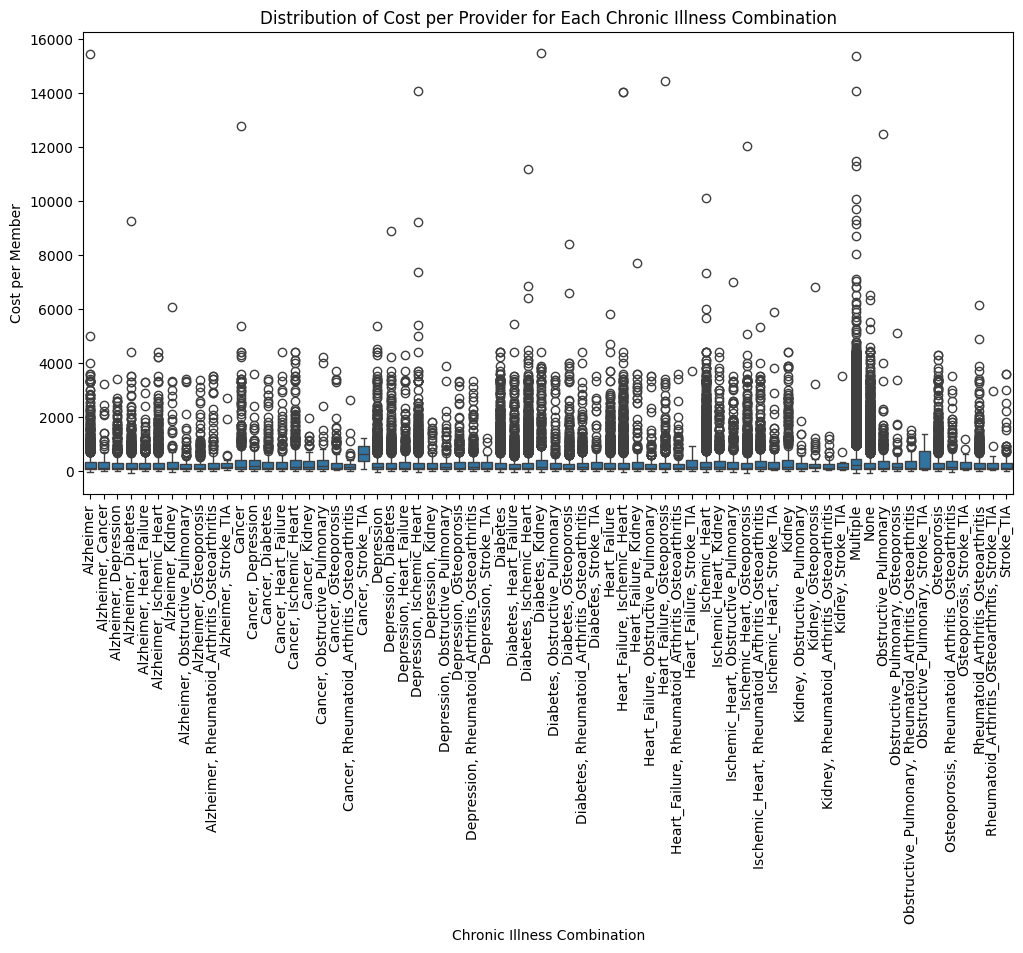

In [275]:
# Step 4: Visualize the distribution of costs per provider for each chronic illness combination
plt.figure(figsize=(12, 6))
sns.boxplot(data=provider_costs_by_illness_reset, x='Chronic_Illness_Combination', y='cost_per_member')
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.title('Distribution of Cost per Provider for Each Chronic Illness Combination')
plt.xlabel('Chronic Illness Combination')
plt.ylabel('Cost per Member')
plt.show()

##### Q: How does this change if we filter out cases where a given Chronic Illness & Provider NPI combination only has one member?

In [287]:
# Sort by cost per member in descending order
sorted_provider_costs_greater1 = provider_costs_by_illness[(provider_costs_by_illness.Chronic_Illness_Combination != 'Multiple') & (provider_costs_by_illness.Chronic_Illness_Combination != 'None') & (provider_costs_by_illness.member_count > 1)].sort_values('total_claim_cost', ascending=False)

# Display the sorted result
sorted_provider_costs_greater1.head(15)

# ?: How can Chronic Illness Combination 'None' have some claims? This could involve Non-Chronic conditions, Preventive care like scans, Miscategorization but it doesn't seem to be the case, Short-term medical care like surgeries and treatments, add to PPT

,Chronic_Illness_Combination,Attending_Physician_NPI,total_claim_cost,member_count
12740,"Diabetes, Ischemic_Heart",2.505840e+08,15380.0,16
13830,"Diabetes, Ischemic_Heart",2.805937e+09,13720.0,2
13714,"Diabetes, Ischemic_Heart",2.534554e+09,9840.0,14
2877,"Alzheimer, Ischemic_Heart",4.201027e+09,8310.0,5
25877,"Ischemic_Heart, Osteoporosis",4.434265e+09,7640.0,4
19820,"Heart_Failure, Ischemic_Heart",6.293393e+08,7110.0,14
25442,"Ischemic_Heart, Osteoporosis",1.507715e+09,7090.0,9
14607,"Diabetes, Ischemic_Heart",4.558708e+09,6810.0,8
13294,"Diabetes, Ischemic_Heart",1.586461e+09,6770.0,27
14177,"Diabetes, Ischemic_Heart",3.553213e+09,6500.0,5


In [278]:
sorted_provider_costs_greater1.shape

(3731, 4)

In [284]:
sorted_provider_costs_greater1.Chronic_Illness_Combination.nunique()

54

In [285]:
sorted_provider_costs_greater1.Attending_Physician_NPI.nunique()

2081

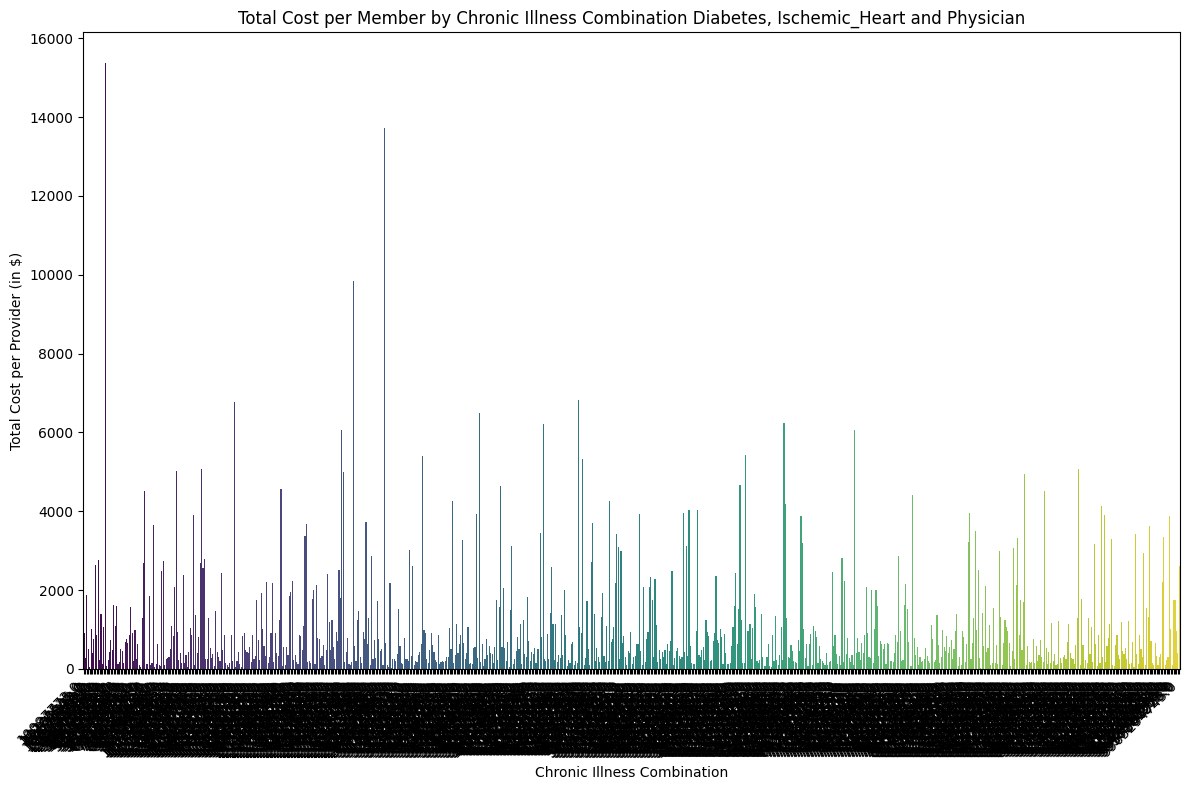

In [292]:
# Filter for a specific chronic illness combination
specific_combination = 'Diabetes, Ischemic_Heart'
filtered_df = sorted_provider_costs_greater1[
    sorted_provider_costs_greater1['Chronic_Illness_Combination'] == specific_combination
]


# Set figure size
plt.figure(figsize=(12, 8))

# Create a bar plot
sns.barplot(
    data=filtered_df,
    x='Attending_Physician_NPI',
    y='total_claim_cost',
    palette='viridis'
)

# Add title and labels
plt.title(f'Total Cost per Member by Chronic Illness Combination {specific_combination} and Physician')
plt.xlabel('Chronic Illness Combination')
plt.ylabel('Total Cost per Provider (in $)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()



##### Q: Which providers are consistently expensive across chronic illnesses they treat?